---
# [MAIN QUEST 01] Space Titanic - 데이터 EDA 및 머신러닝 모델링

**작성자:** 김창일
**작성일:** 2026.01.26
**과제:**  Main Quest 01
**목표:** Space Titanic 데이터 분석 및 Transported 예측 모델 개발 (정확도 80.5% 이상)

---

##  목차 (Table of Contents)

1. [프로젝트 개요](#1-프로젝트-개요)
2. [데이터 로드 및 기본 정보 확인](#2-데이터-로드-및-기본-정보-확인)
3. [타겟 변수 및 결측치 분석](#3-타겟-변수-및-결측치-분석)
4. [탐색적 데이터 분석 (EDA)](#4-탐색적-데이터-분석-eda)
   - 4.1 범주형 변수 분포
   - 4.2 Cabin 구조 분석
   - 4.3 변수별 Transported 관계
   - 4.4 소비 패턴 분석
   - 4.5 그룹 분석
   - 4.6 Name 분석
5. [데이터 전처리](#5-데이터-전처리)
   - 5.1 결측치 처리
   - 5.2 파생 변수 생성
   - 5.3 인코딩
6. [모델링](#6-모델링)
   - 6.1 Baseline 모델
   - 6.2 하이퍼파라미터 튜닝
   - 6.3 최종 모델 선택
7. [Test 예측 및 제출](#7-test-예측-및-제출)
8. [결과 요약 (Summary)](#8-결과-요약-summary)
9. [회고 (Reflection)](#9-회고-reflection)

---

## 1. 프로젝트 개요

### 1.1 배경
Space Titanic은 Kaggle의 타이타닉 생존 예측 문제를 변형한 데이터셋으로, 우주선 승객들이 다른 차원으로 이동(Transported)했는지 예측하는 이진 분류 문제입니다.

### 1.2 목표
- Space Titanic 데이터를 탐색적으로 분석(EDA)
- 승객의 Transported 여부를 예측하는 머신러닝 모델 개발
- **정확도 80.5% 이상 달성**

### 1.3 데이터셋 구조
- **Train 데이터:** 8,693명의 승객 (14개 변수)
- **Test 데이터:** 4,277명의 승객 (13개 변수, Transported 제외)
- **주요 변수:**
  - PassengerId: 승객 고유 ID
  - HomePlanet: 출발 행성
  - CryoSleep: 냉동수면 여부
  - Cabin: 객실 번호
  - Destination: 목적지
  - Age: 나이
  - VIP: VIP 여부
  - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: 소비 금액
  - Name: 이름
  - **Transported (타겟):** 다른 차원으로 이동했는지 여부

---


In [28]:

# 기본 라이브러리
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msno

# 머신러닝
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 랜덤 시드 고정
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("=" * 60)
print("Space Titanic EDA & Modeling Project")
print("=" * 60)
print("✅ 라이브러리 임포트 완료")

Space Titanic EDA & Modeling Project
✅ 라이브러리 임포트 완료


In [29]:
# ============================================================
# 1. 데이터 로드
# ============================================================

# 데이터 로드
train_df= pd.read_csv('/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/train.csv')
test_df = pd.read_csv('/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/test.csv')
submission_df = pd.read_csv('/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/sample_submission.csv')


print("=" * 60)
print("1. 데이터 로드 완료")
print("=" * 60)
print(f"Train 데이터 크기: {train_df.shape}")
print(f"Test 데이터 크기: {test_df.shape}")
print(f"Submission 데이터 크기: {submission_df.shape}")

# ============================================================
# 2. 기본 정보 확인
# ============================================================

print("\n" + "=" * 60)
print("2. Train 데이터 기본 정보")
print("=" * 60)
print("\n[컬럼 목록]")
print(train_df.columns.tolist())

print("\n[데이터 타입 및 결측치]")
train_df.info()

print("\n[처음 5개 행]")
display(train_df.head())

print("\n[수치 통계]")
display(train_df.describe())

print("\n[각 컬럼의 고유값 개수]")
print(train_df.nunique())

1. 데이터 로드 완료
Train 데이터 크기: (8693, 14)
Test 데이터 크기: (4277, 13)
Submission 데이터 크기: (4277, 2)

2. Train 데이터 기본 정보

[컬럼 목록]
['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

[데이터 타입 및 결측치]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null 

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



[수치 통계]


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



[각 컬럼의 고유값 개수]
PassengerId     8693
HomePlanet         3
CryoSleep          2
Cabin           6560
Destination        3
Age               80
VIP                2
RoomService     1273
FoodCourt       1507
ShoppingMall    1115
Spa             1327
VRDeck          1306
Name            8473
Transported        2
dtype: int64


####  3. 타겟 변수(Transported) 분석

3-1. 타겟 변수 분포 확인

[Transported 개수]
Transported
True     4378
False    4315
Name: count, dtype: int64

[Transported 비율]
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


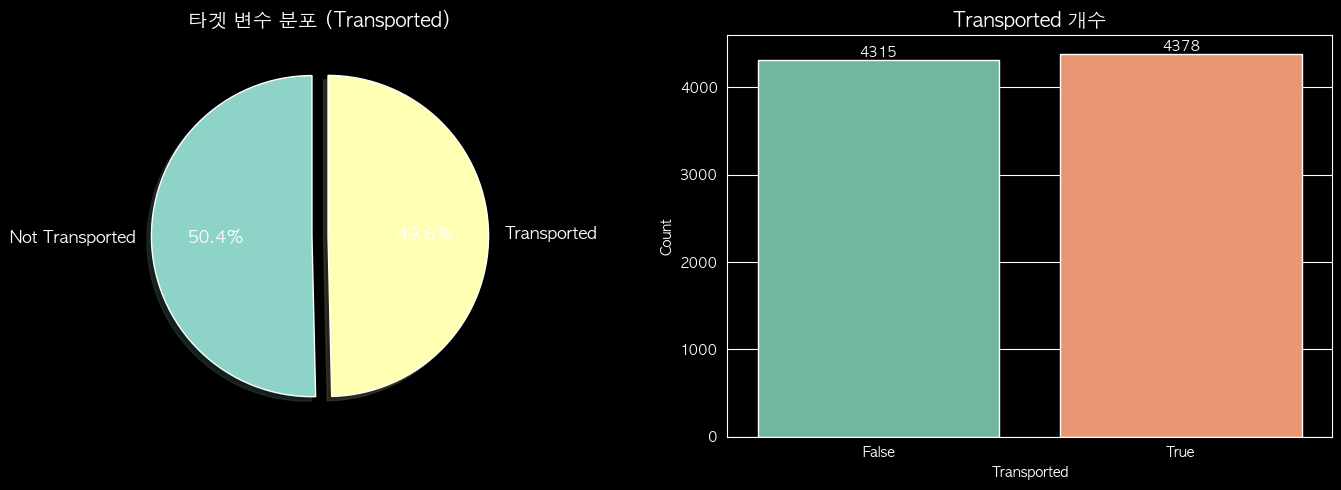


3-2. 결측치 현황

[결측치 상세 정보]
              결측치 개수  결측치 비율(%)
CryoSleep        217   2.496261
ShoppingMall     208   2.392730
VIP              203   2.335212
HomePlanet       201   2.312205
Name             200   2.300702
Cabin            199   2.289198
VRDeck           188   2.162660
FoodCourt        183   2.105142
Spa              183   2.105142
Destination      182   2.093639
RoomService      181   2.082135
Age              179   2.059128

[결측치 패턴 시각화]


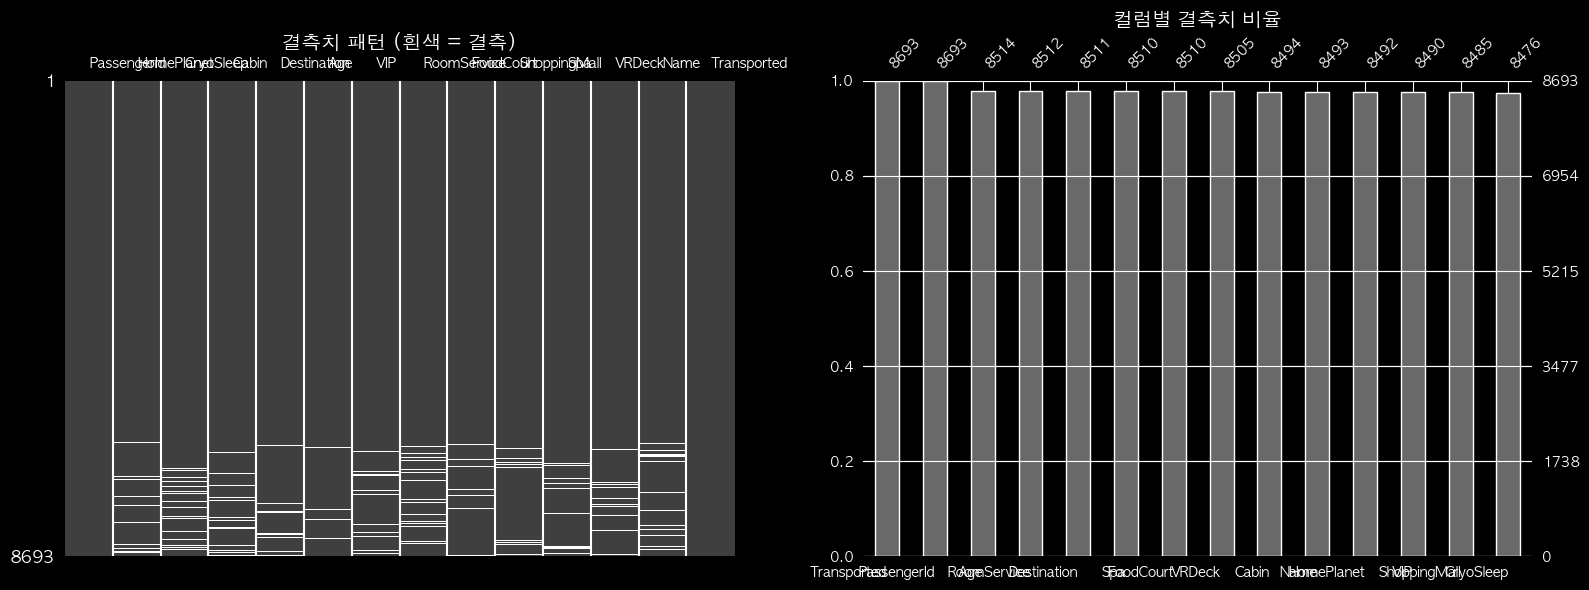


💡 인사이트:
- 타겟 변수는 결측치가 없음 ✅
- 대부분의 컬럼에서 약 2-3%의 결측치 발견
- 결측치 패턴을 보면 특정 행에서 여러 컬럼이 동시에 결측되는 경향 있음


In [30]:
# ============================================================
# 3. 타겟 변수(Transported) 분석
# ============================================================

print("=" * 60)
print("3-1. 타겟 변수 분포 확인")
print("=" * 60)

# 타겟 변수 개수 및 비율
target_counts = train_df['Transported'].value_counts()
target_ratio = train_df['Transported'].value_counts(normalize=True)

print("\n[Transported 개수]")
print(target_counts)
print("\n[Transported 비율]")
print(target_ratio)

# 파이 차트로 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 왼쪽: 파이 차트
axes[0].pie(target_counts,
            labels=['Not Transported', 'Transported'],
            autopct='%1.1f%%',
            explode=[0.05, 0.05],
            shadow=True,
            startangle=90,
            textprops={'fontsize': 12})
axes[0].set_title('타겟 변수 분포 (Transported)', fontsize=14, fontweight='bold')

# 오른쪽: 바 차트
sns.countplot(data=train_df, x='Transported', ax=axes[1], palette='Set2')
axes[1].set_title('Transported 개수', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Transported')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=0)  # x축 수평

# 바 위에 숫자 표시
for p in axes[1].patches:
    axes[1].text(p.get_x() + p.get_width()/2., p.get_height(),
                f'{int(p.get_height())}',
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ============================================================
# 3-2. 결측치 분석
# ============================================================

print("\n" + "=" * 60)
print("3-2. 결측치 현황")
print("=" * 60)

# 결측치 개수 및 비율 계산
missing_count = train_df.isnull().sum()
missing_ratio = (train_df.isnull().sum() / len(train_df)) * 100

missing_df = pd.DataFrame({
    '결측치 개수': missing_count,
    '결측치 비율(%)': missing_ratio
}).sort_values('결측치 개수', ascending=False)

print("\n[결측치 상세 정보]")
print(missing_df[missing_df['결측치 개수'] > 0])

# missingno를 사용한 시각화
print("\n[결측치 패턴 시각화]")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 왼쪽: 결측치 행렬
msno.matrix(train_df, ax=axes[0], fontsize=10, sort='descending')
axes[0].set_title('결측치 패턴 (흰색 = 결측)', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)  # x축 수평

# 오른쪽: 결측치 바 차트
msno.bar(train_df, ax=axes[1], fontsize=10, sort='descending')
axes[1].set_title('컬럼별 결측치 비율', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=0)  # x축 수평

plt.tight_layout()
plt.show()

print("\n💡 인사이트:")
print("- 타겟 변수는 결측치가 없음 ✅")
print("- 대부분의 컬럼에서 약 2-3%의 결측치 발견")
print("- 결측치 패턴을 보면 특정 행에서 여러 컬럼이 동시에 결측되는 경향 있음")

4-1. 범주형 변수 분포 분석

[HomePlanet]
HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64
결측치: 201개

[CryoSleep]
CryoSleep
False    5439
True     3037
Name: count, dtype: int64
결측치: 217개

[Destination]
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64
결측치: 182개

[VIP]
VIP
False    8291
True      199
Name: count, dtype: int64
결측치: 203개

4-2. Cabin 구조 분석

[Cabin 샘플]
0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
5    F/0/P
6    F/2/S
7    G/0/S
8    F/3/S
9    B/1/P
Name: Cabin, dtype: object

[Cabin 분리 작업 수행]
✅ Cabin 분리 완료: Deck, Cabin_num, Side

[Deck 분포]
Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

[Side 분포]
Side
S    4288
P    4206
Name: count, dtype: int64

4-3. 각 컬럼의 고유값(unique) 개수
PassengerId     8693
Name            8473
Cabin           6560
Cabin_num       1817
FoodCourt       1507
Spa             1327
VRDeck          1306
RoomS

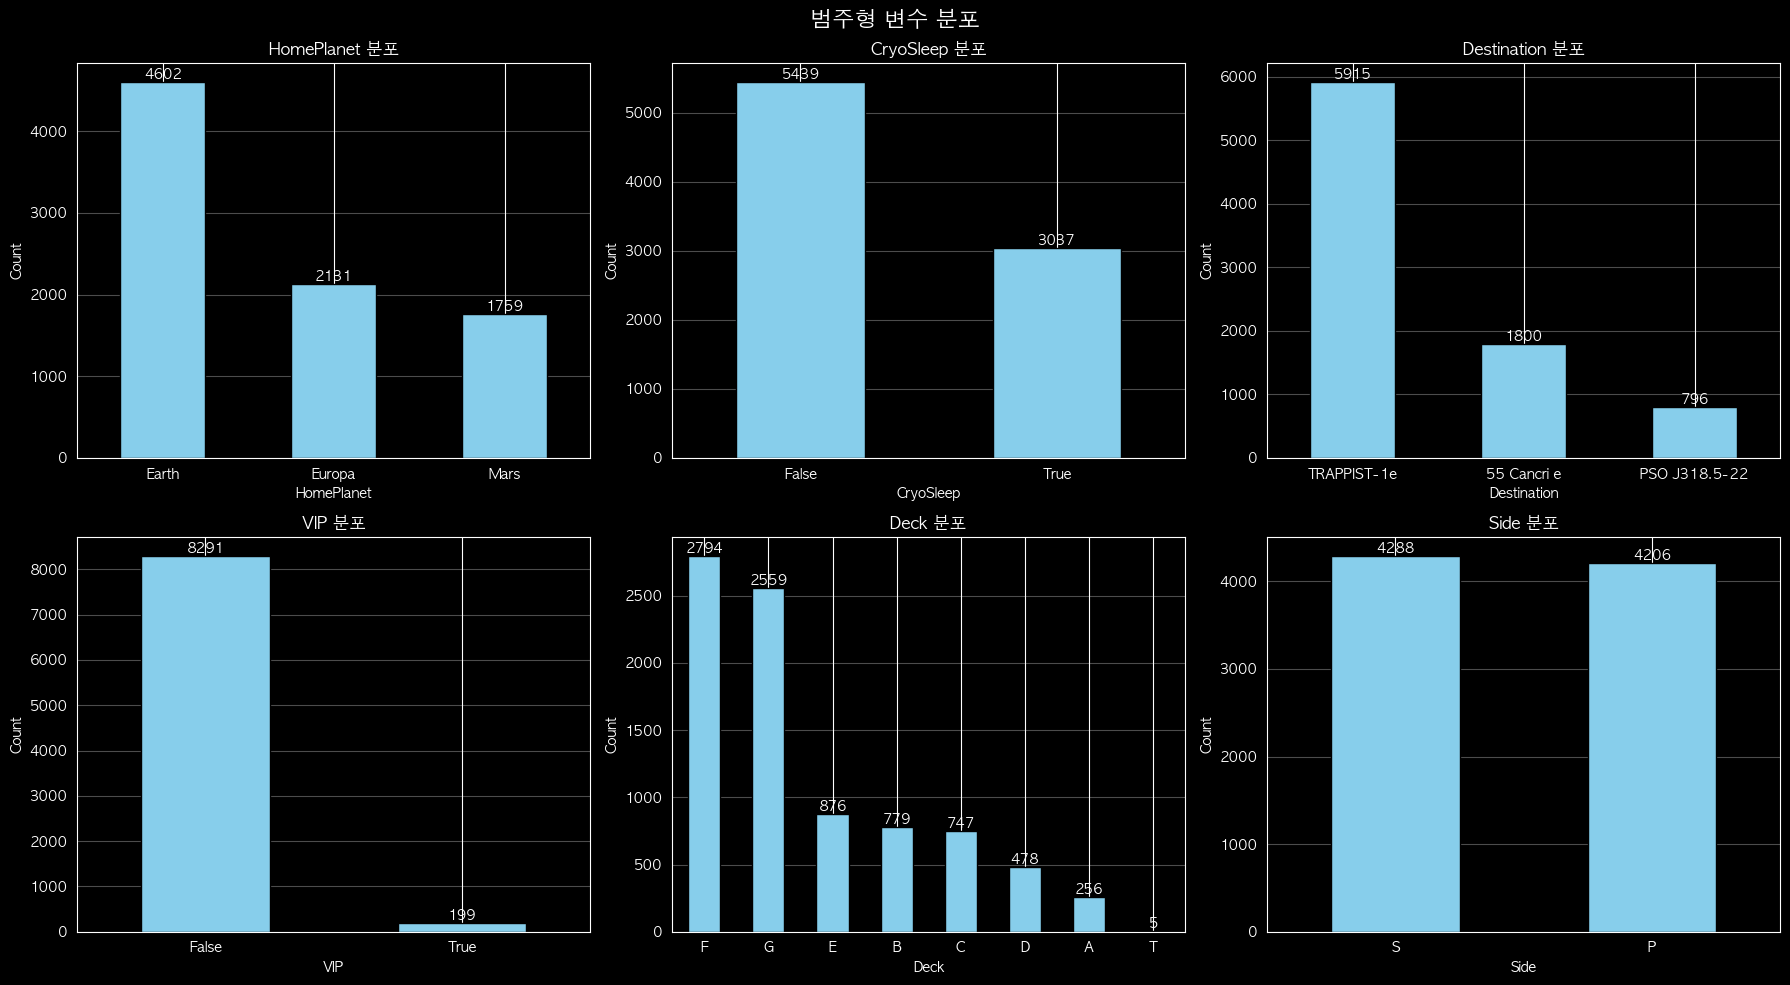


💡 인사이트:
- HomePlanet: Earth가 가장 많음 (53%)
- CryoSleep: False가 더 많음 (64%)
- Destination: TRAPPIST-1e가 압도적 (69%)
- VIP: 극소수만 VIP (2.4%)
- Deck: F, G가 가장 많음
- Side: P(Port)와 S(Starboard) 거의 동일


In [31]:
# ============================================================
# 4. 범주형 변수 분포 확인
# ============================================================

print("=" * 60)
print("4-1. 범주형 변수 분포 분석")
print("=" * 60)

# 범주형 변수 리스트
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for col in categorical_cols:
    print(f"\n[{col}]")
    print(train_df[col].value_counts())
    print(f"결측치: {train_df[col].isnull().sum()}개")
    print("=" * 40)

# ============================================================
# 4-2. Cabin 구조 분석 및 Deck 추출
# ============================================================

print("\n" + "=" * 60)
print("4-2. Cabin 구조 분석")
print("=" * 60)

print("\n[Cabin 샘플]")
print(train_df['Cabin'].dropna().head(10))

# Cabin을 Deck/Num/Side로 분리
print("\n[Cabin 분리 작업 수행]")
train_df['Deck'] = train_df['Cabin'].str.split('/').str[0]
train_df['Cabin_num'] = train_df['Cabin'].str.split('/').str[1]
train_df['Side'] = train_df['Cabin'].str.split('/').str[2]

test_df['Deck'] = test_df['Cabin'].str.split('/').str[0]
test_df['Cabin_num'] = test_df['Cabin'].str.split('/').str[1]
test_df['Side'] = test_df['Cabin'].str.split('/').str[2]

print("✅ Cabin 분리 완료: Deck, Cabin_num, Side")

print("\n[Deck 분포]")
print(train_df['Deck'].value_counts())

print("\n[Side 분포]")
print(train_df['Side'].value_counts())

# ============================================================
# 4-3. 고유값 개수 확인
# ============================================================

print("\n" + "=" * 60)
print("4-3. 각 컬럼의 고유값(unique) 개수")
print("=" * 60)
print(train_df.nunique().sort_values(ascending=False))

# ============================================================
# 4-4. 범주형 변수 시각화
# ============================================================

print("\n" + "=" * 60)
print("4-4. 범주형 변수 시각화")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('범주형 변수 분포', fontsize=16, fontweight='bold')

# 시각화할 변수들
viz_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

for idx, col in enumerate(viz_cols):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]

    # 카운트 플롯
    data_counts = train_df[col].value_counts()
    data_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

    ax.set_title(f'{col} 분포', fontsize=12, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=0)  # x축 수평
    ax.grid(axis='y', alpha=0.3)

    # 바 위에 숫자 표시
    for container in ax.containers:
        ax.bar_label(container)

plt.tight_layout()
plt.show()

print("\n💡 인사이트:")
print("- HomePlanet: Earth가 가장 많음 (53%)")
print("- CryoSleep: False가 더 많음 (64%)")
print("- Destination: TRAPPIST-1e가 압도적 (69%)")
print("- VIP: 극소수만 VIP (2.4%)")
print("- Deck: F, G가 가장 많음")
print("- Side: P(Port)와 S(Starboard) 거의 동일")

#### <span style = "color:pink"> 변수별 Transported와  상관 관계 분석<span/>

5-1. 범주형 변수와 Transported 관계

[HomePlanet vs Transported]
Transported     False     True 
HomePlanet                     
Earth        0.576054  0.423946
Europa       0.341154  0.658846
Mars         0.476976  0.523024
----------------------------------------

[CryoSleep vs Transported]
Transported     False     True 
CryoSleep                      
False        0.671079  0.328921
True         0.182417  0.817583
----------------------------------------

[Destination vs Transported]
Transported       False     True 
Destination                      
55 Cancri e    0.390000  0.610000
PSO J318.5-22  0.496231  0.503769
TRAPPIST-1e    0.528825  0.471175
----------------------------------------

[VIP vs Transported]
Transported     False     True 
VIP                            
False        0.493668  0.506332
True         0.618090  0.381910
----------------------------------------

[Deck vs Transported]
Transported     False     True 
Deck                           
A            0.503906  0.4

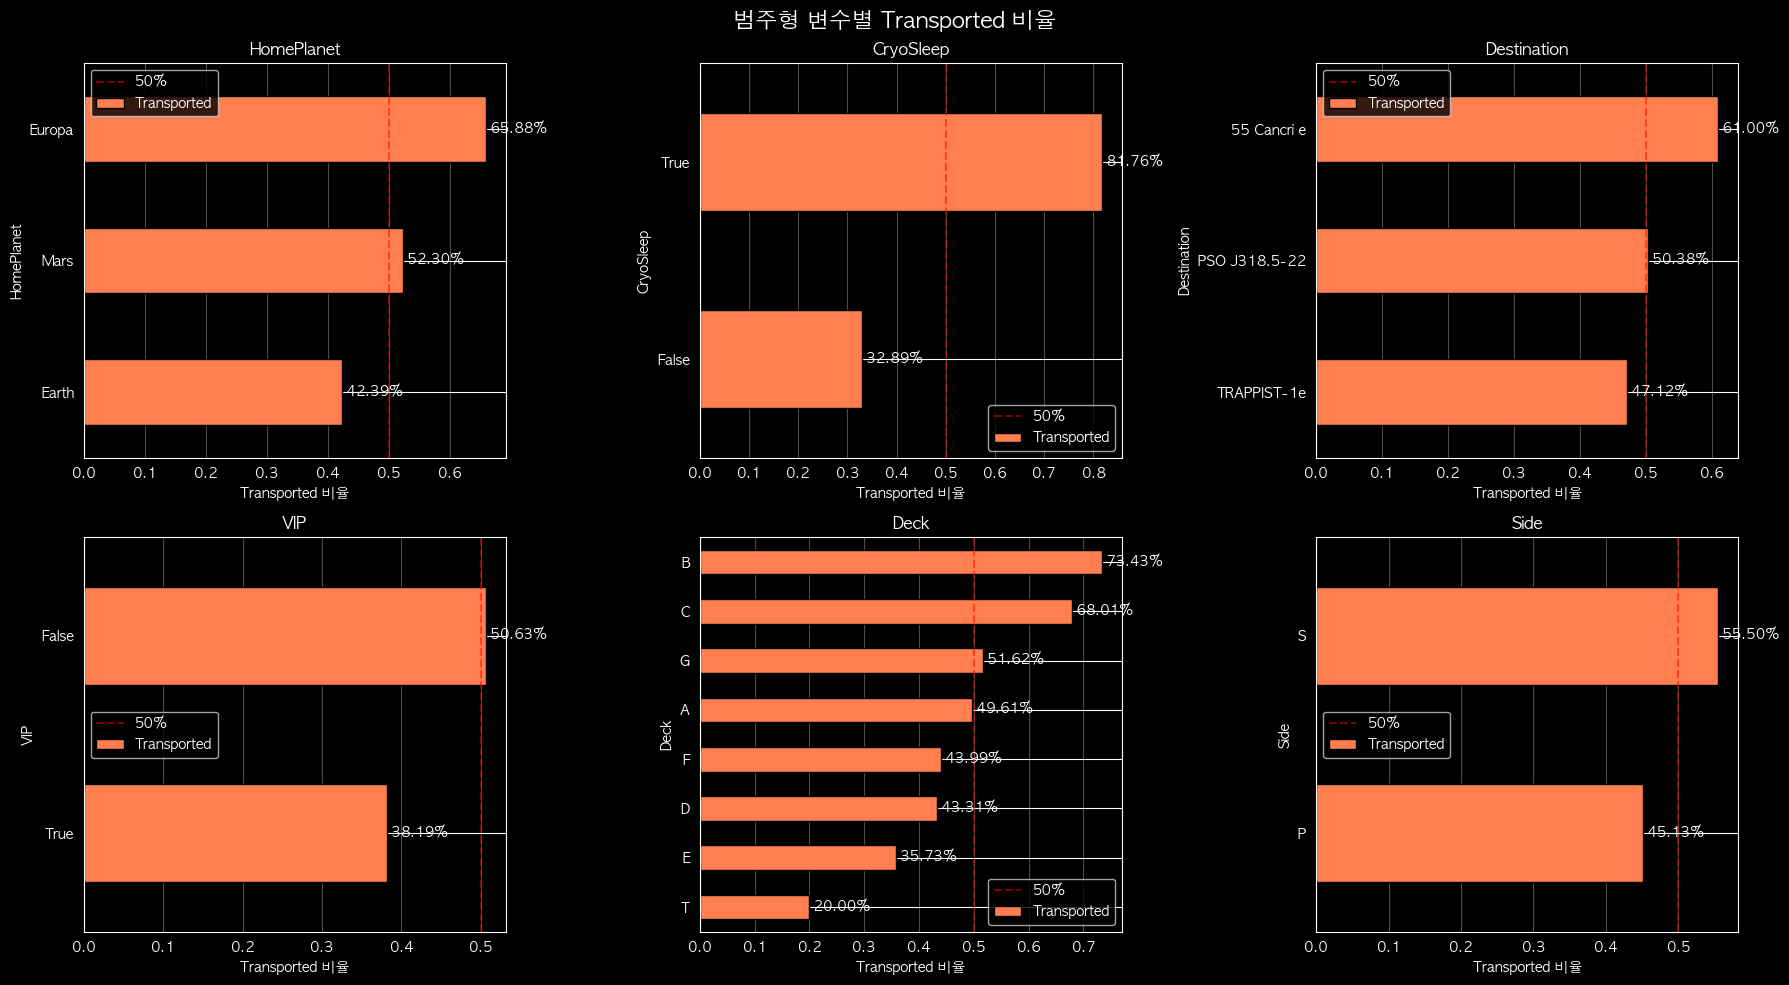


5-3. Age vs Transported 분석

[Age 기술 통계]
              count       mean        std  min   25%   50%   75%   max
Transported                                                           
False        4226.0  29.922858  13.699262  0.0  21.0  27.0  38.0  79.0
True         4288.0  27.748834  15.151705  0.0  18.0  26.0  37.0  78.0


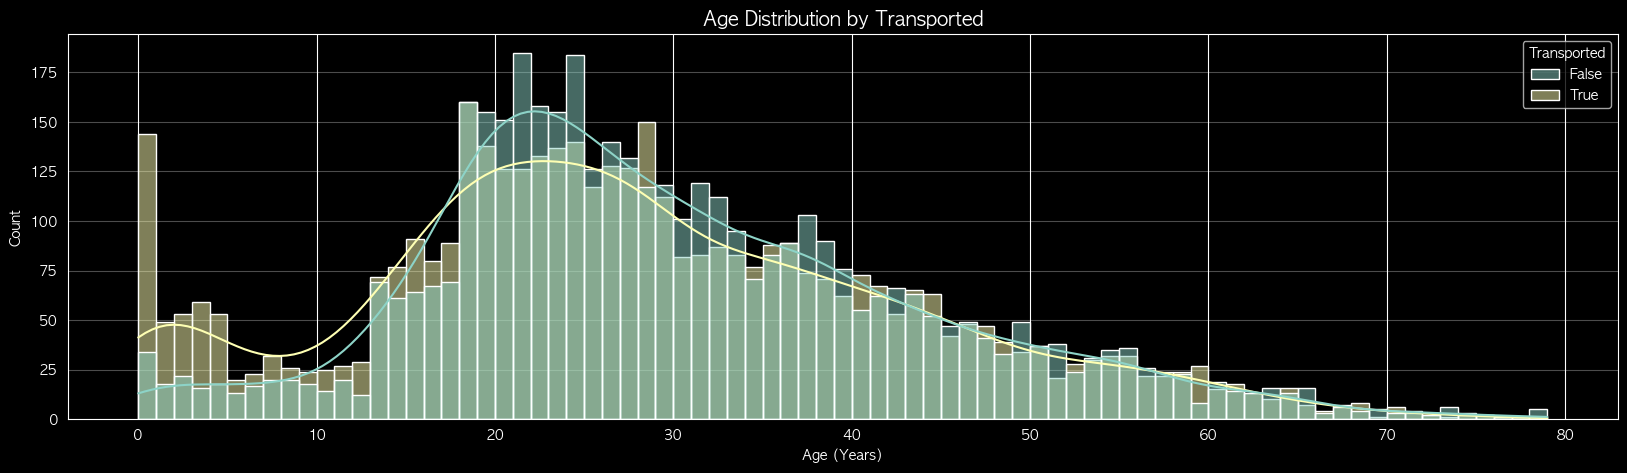


💡 Age 인사이트:
- 0~18세: Transported 비율이 높음
- 18~40세: Not Transported 비율이 높음
- 40세 이상: 혼재됨


In [32]:
# ============================================================
# 5. 변수별 Transported 관계 분석
# ============================================================

print("=" * 60)
print("5-1. 범주형 변수와 Transported 관계")
print("=" * 60)

# 범주형 변수별 Transported 비율
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']

for col in categorical_features:
    print(f"\n[{col} vs Transported]")
    crosstab = pd.crosstab(train_df[col], train_df['Transported'], normalize='index')
    print(crosstab)
    print("-" * 40)

# ============================================================
# 5-2. 범주형 변수와 Transported 시각화
# ============================================================

print("\n" + "=" * 60)
print("5-2. 범주형 변수와 Transported 시각화")
print("=" * 60)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('범주형 변수별 Transported 비율', fontsize=16, fontweight='bold')

for idx, col in enumerate(categorical_features):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]

    # 각 카테고리별 Transported 비율 계산
    transported_rate = train_df.groupby(col)['Transported'].mean().sort_values()

    # 수평 막대 그래프
    transported_rate.plot(kind='barh', ax=ax, color='coral', edgecolor='black')
    ax.set_xlabel('Transported 비율')
    ax.set_title(f'{col}')
    ax.grid(axis='x', alpha=0.3)

    # 비율 값 표시
    for i, v in enumerate(transported_rate.values):
        ax.text(v, i, f' {v:.2%}', va='center', fontweight='bold')

    # 50% 기준선
    ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='50%')
    ax.legend()

plt.tight_layout()
plt.show()

# ============================================================
# 5-3. Age vs Transported 분석 (Baseline 2.4.2 참고)
# ============================================================

print("\n" + "=" * 60)
print("5-3. Age vs Transported 분석")
print("=" * 60)

# Age 통계
print("\n[Age 기술 통계]")
print(train_df.groupby('Transported')['Age'].describe())

# 히스토그램
plt.figure(figsize=(20, 5))
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True, bins=80)
plt.title('Age Distribution by Transported', fontsize=14, fontweight='bold')
plt.xlabel('Age (Years)')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("\n💡 Age 인사이트:")
print("- 0~18세: Transported 비율이 높음")
print("- 18~40세: Not Transported 비율이 높음")
print("- 40세 이상: 혼재됨")

6-1. 소비 변수 기본 통계

[소비 변수 기술 통계]


,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,224.687617,458.077203,173.729169,311.138778,304.854791
std,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,47.000000,76.000000,27.000000,59.000000,46.000000
max,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



6-2. 총 소비액 파생 변수 생성
✅ TotalSpending 변수 생성 완료

[총 소비액 통계]
count     8693.000000
mean      1440.866329
std       2803.045694
min          0.000000
25%          0.000000
50%        716.000000
75%       1441.000000
max      35987.000000
Name: TotalSpending, dtype: float64

[소비 여부 분포]
HasSpending
1    5040
0    3653
Name: count, dtype: int64
소비 안함(0원): 3653명
소비 함: 5040명

6-3. 소비 패턴과 Transported 관계

[소비 여부별 Transported 비율]
Transported     False     True 
HasSpending                    
0            0.213523  0.786477
1            0.701389  0.298611

[Transported별 평균 소비액]
             RoomService   FoodCourt  ShoppingMall         Spa      VRDeck  \
Transported                                                                  
False         389.266066  382.615930    167.566217  564.382666  543.629822   
True           63.098021  532.691984    179.829972   61.675531   69.148131   

             TotalSpending  
Transported                 
False          2004.149247  
True            885.689127 

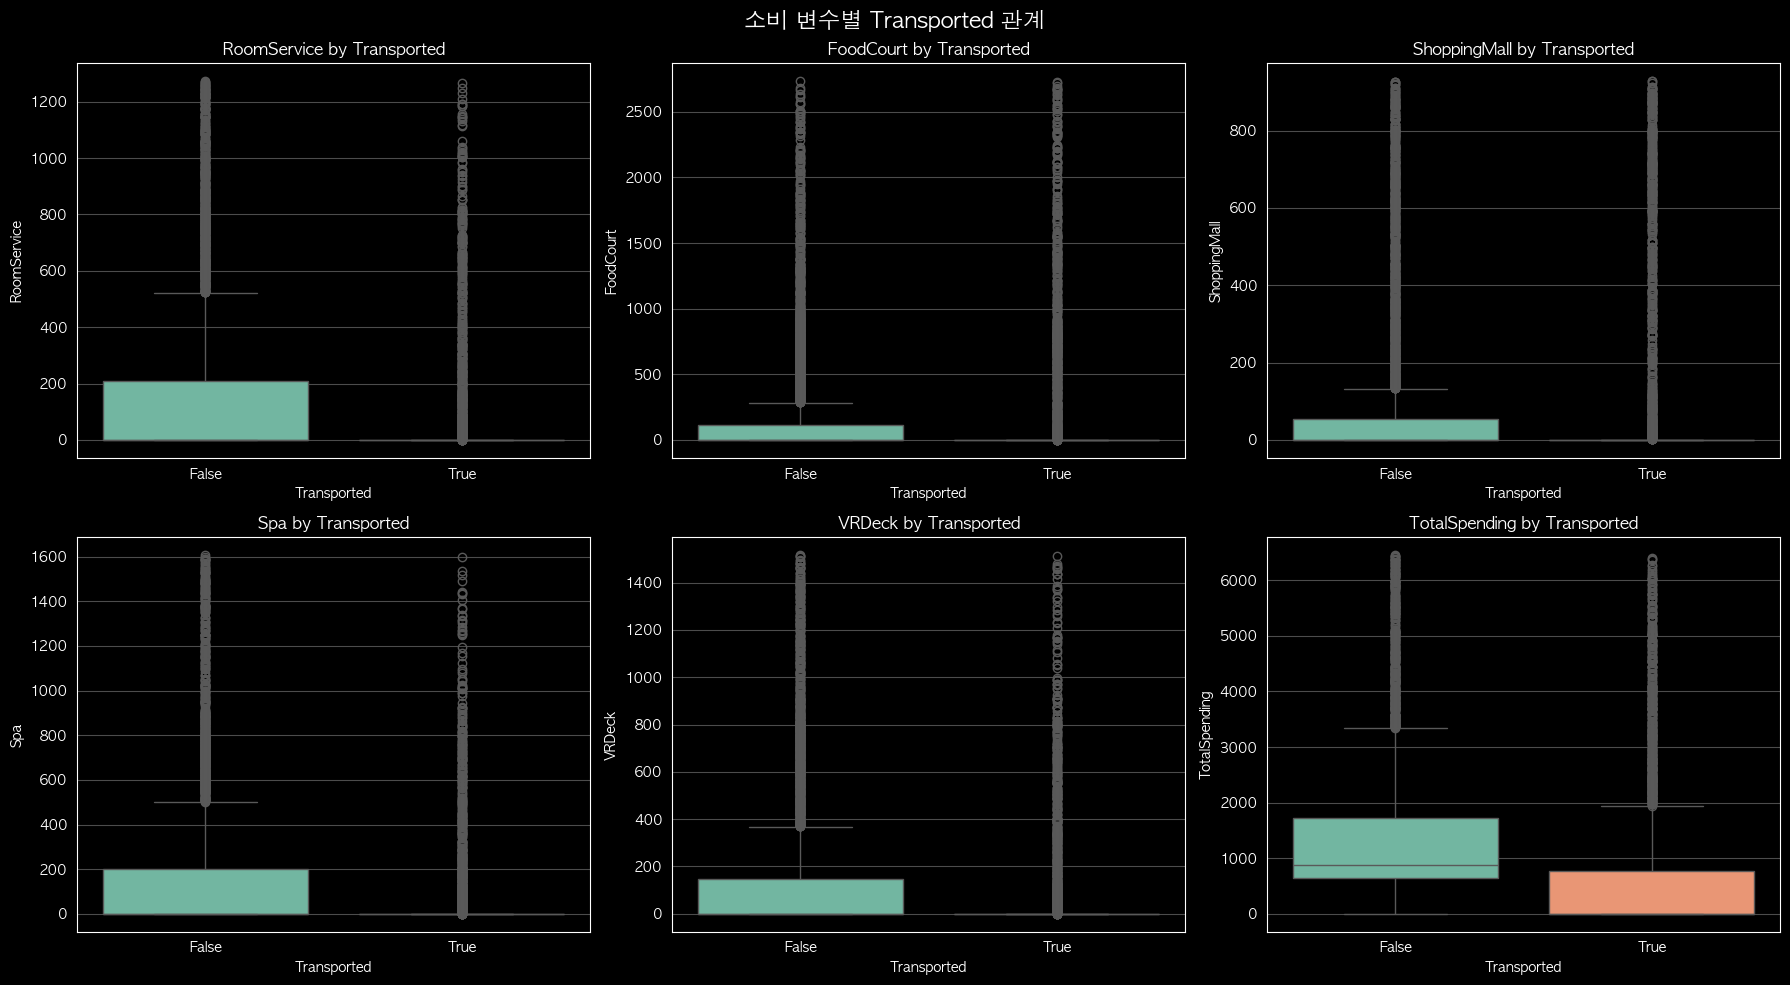

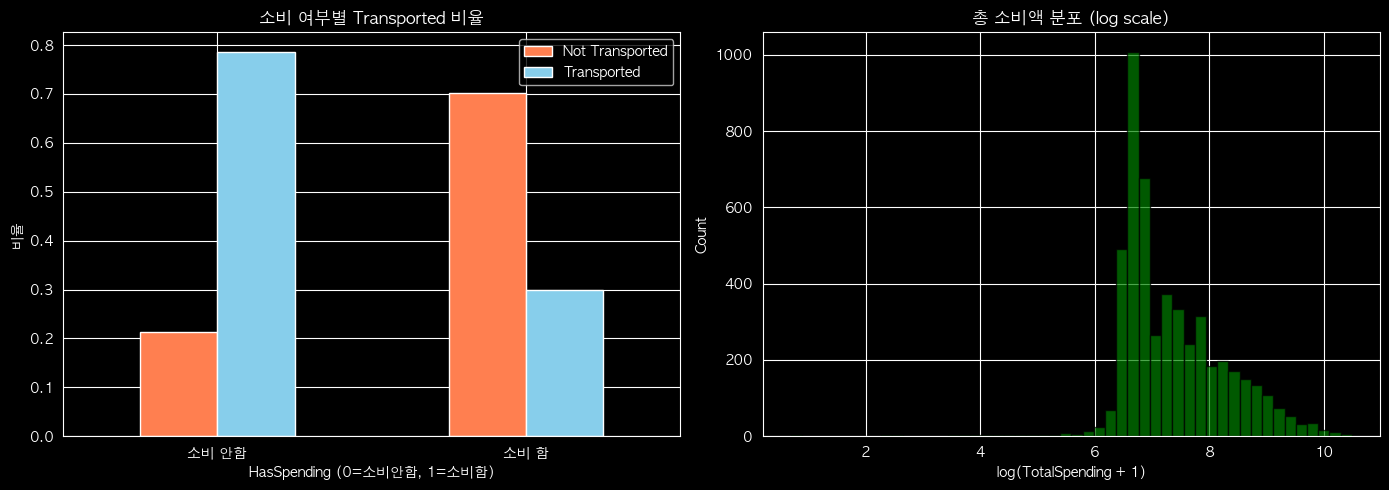


💡 소비 패턴 인사이트:
- 소비를 안 한 승객의 이동 비율을 확인
- 각 소비 카테고리별 차이 파악
- TotalSpending 파생 변수 생성 → 모델에 활용 가능


In [33]:
# ============================================================
# 6. 소비 변수(지출) 분석
# ============================================================

print("=" * 60)
print("6-1. 소비 변수 기본 통계")
print("=" * 60)

# 소비 관련 컬럼
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

print("\n[소비 변수 기술 통계]")
display(train_df[spending_cols].describe())

# ============================================================
# 6-2. 총 소비액 계산
# ============================================================

print("\n" + "=" * 60)
print("6-2. 총 소비액 파생 변수 생성")
print("=" * 60)

# 총 소비액 계산 (NaN은 0으로 처리)
train_df['TotalSpending'] = train_df[spending_cols].fillna(0).sum(axis=1)
test_df['TotalSpending'] = test_df[spending_cols].fillna(0).sum(axis=1)

print("✅ TotalSpending 변수 생성 완료")
print(f"\n[총 소비액 통계]")
print(train_df['TotalSpending'].describe())

# 소비 여부 (0원 vs 소비함)
train_df['HasSpending'] = (train_df['TotalSpending'] > 0).astype(int)
test_df['HasSpending'] = (test_df['TotalSpending'] > 0).astype(int)

print(f"\n[소비 여부 분포]")
print(train_df['HasSpending'].value_counts())
print(f"소비 안함(0원): {(train_df['HasSpending']==0).sum()}명")
print(f"소비 함: {(train_df['HasSpending']==1).sum()}명")

# ============================================================
# 6-3. 소비 패턴과 Transported 관계
# ============================================================

print("\n" + "=" * 60)
print("6-3. 소비 패턴과 Transported 관계")
print("=" * 60)

# 소비 여부별 Transported 비율
print("\n[소비 여부별 Transported 비율]")
print(pd.crosstab(train_df['HasSpending'], train_df['Transported'], normalize='index'))

# Transported별 평균 소비액
print("\n[Transported별 평균 소비액]")
print(train_df.groupby('Transported')[spending_cols + ['TotalSpending']].mean())

# ============================================================
# 6-4. 소비 변수 시각화
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('소비 변수별 Transported 관계', fontsize=16, fontweight='bold')

# 각 소비 변수 + 총 소비액
viz_spending = spending_cols + ['TotalSpending']

for idx, col in enumerate(viz_spending):
    row = idx // 3
    col_idx = idx % 3
    ax = axes[row, col_idx]

    # 박스플롯 (이상치 제거를 위해 상위 95% 이내만)
    data_to_plot = train_df[train_df[col] <= train_df[col].quantile(0.95)]

    sns.boxplot(data=data_to_plot, x='Transported', y=col, ax=ax, palette='Set2')
    ax.set_title(f'{col} by Transported', fontweight='bold')
    ax.set_ylabel(col)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================
# 6-5. 소비 여부 시각화
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 소비 여부별 Transported 비율
spending_transported = pd.crosstab(train_df['HasSpending'],
                                   train_df['Transported'],
                                   normalize='index')

spending_transported.plot(kind='bar', ax=axes[0], color=['coral', 'skyblue'])
axes[0].set_title('소비 여부별 Transported 비율', fontweight='bold')
axes[0].set_xlabel('HasSpending (0=소비안함, 1=소비함)')
axes[0].set_ylabel('비율')
axes[0].legend(['Not Transported', 'Transported'])
axes[0].set_xticklabels(['소비 안함', '소비 함'], rotation=0)

# 총 소비액 분포 (로그 스케일)
train_df[train_df['TotalSpending'] > 0]['TotalSpending'].apply(np.log1p).hist(
    bins=50, ax=axes[1], color='green', edgecolor='black', alpha=0.7)
axes[1].set_title('총 소비액 분포 (log scale)', fontweight='bold')
axes[1].set_xlabel('log(TotalSpending + 1)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

print("\n💡 소비 패턴 인사이트:")
print("- 소비를 안 한 승객의 이동 비율을 확인")
print("- 각 소비 카테고리별 차이 파악")
print("- TotalSpending 파생 변수 생성 → 모델에 활용 가능")

7-1. PassengerId에서 그룹 정보 추출

[PassengerId 샘플]
0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
5    0005_01
6    0006_01
7    0006_02
8    0007_01
9    0008_01
Name: PassengerId, dtype: object
✅ Group, GroupMember 추출 완료

7-2. 그룹 크기 분석
✅ GroupSize 변수 생성 완료

[그룹 크기 분포]
GroupSize
1    4805
2    1682
3    1020
4     412
5     265
6     174
7     231
8     104
Name: count, dtype: int64

[그룹 크기 통계]
혼자 여행: 4805명 (55.3%)
2인 그룹: 1682명
3인 이상: 2206명
최대 그룹 크기: 8명

✅ IsAlone 변수 생성 완료
IsAlone
1    4805
0    3888
Name: count, dtype: int64

7-4. 그룹 크기와 Transported 관계

[그룹 크기별 Transported 비율]
GroupSize
1    0.452445
2    0.538050
3    0.593137
4    0.640777
5    0.592453
6    0.614943
7    0.541126
8    0.394231
Name: Transported, dtype: float64

[혼자 vs 일행 Transported 비율]
IsAlone
0    0.566872
1    0.452445
Name: Transported, dtype: float64


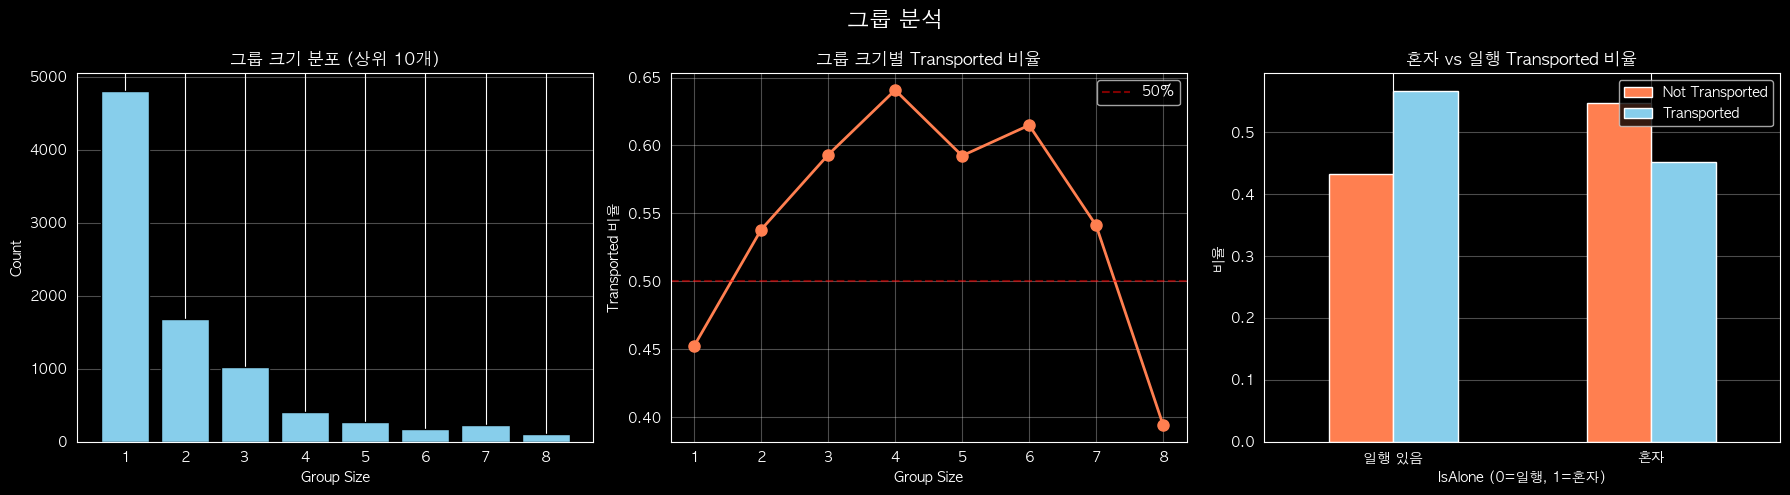


💡 그룹 분석 인사이트:
- Group, GroupSize, IsAlone 파생 변수 생성
- 그룹 크기에 따른 Transported 패턴 확인
- 혼자 vs 일행의 이동 비율 차이 파악


In [34]:
# ============================================================
# 7. PassengerId 그룹 분석
# ============================================================

print("=" * 60)
print("7-1. PassengerId에서 그룹 정보 추출")
print("=" * 60)

# PassengerId 샘플 확인
print("\n[PassengerId 샘플]")
print(train_df['PassengerId'].head(10))

# 그룹 정보 추출
train_df['Group'] = train_df['PassengerId'].str.split('_').str[0]
train_df['GroupMember'] = train_df['PassengerId'].str.split('_').str[1]

test_df['Group'] = test_df['PassengerId'].str.split('_').str[0]
test_df['GroupMember'] = test_df['PassengerId'].str.split('_').str[1]

print("✅ Group, GroupMember 추출 완료")

# ============================================================
# 7-2. 그룹 크기 계산 (transform 사용 - 더 안정적)
# ============================================================

print("\n" + "=" * 60)
print("7-2. 그룹 크기 분석")
print("=" * 60)

# transform을 사용하여 그룹 크기 계산 (merge 대신)
train_df['GroupSize'] = train_df.groupby('Group')['Group'].transform('count')
test_df['GroupSize'] = test_df.groupby('Group')['Group'].transform('count')

print("✅ GroupSize 변수 생성 완료")

print("\n[그룹 크기 분포]")
print(train_df['GroupSize'].value_counts().sort_index().head(10))

print(f"\n[그룹 크기 통계]")
print(f"혼자 여행: {(train_df['GroupSize'] == 1).sum()}명 ({(train_df['GroupSize'] == 1).sum()/len(train_df)*100:.1f}%)")
print(f"2인 그룹: {(train_df['GroupSize'] == 2).sum()}명")
print(f"3인 이상: {(train_df['GroupSize'] >= 3).sum()}명")
print(f"최대 그룹 크기: {train_df['GroupSize'].max()}명")

# ============================================================
# 7-3. 혼자 여부 변수 생성
# ============================================================

train_df['IsAlone'] = (train_df['GroupSize'] == 1).astype(int)
test_df['IsAlone'] = (test_df['GroupSize'] == 1).astype(int)

print("\n✅ IsAlone 변수 생성 완료")
print(train_df['IsAlone'].value_counts())

# ============================================================
# 7-4. 그룹 크기와 Transported 관계
# ============================================================

print("\n" + "=" * 60)
print("7-4. 그룹 크기와 Transported 관계")
print("=" * 60)

# 그룹 크기별 Transported 비율
print("\n[그룹 크기별 Transported 비율]")
group_transported = train_df.groupby('GroupSize')['Transported'].mean()
print(group_transported.head(10))

# 혼자 vs 일행
print("\n[혼자 vs 일행 Transported 비율]")
print(train_df.groupby('IsAlone')['Transported'].mean())

# ============================================================
# 7-5. 시각화
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('그룹 분석', fontsize=16, fontweight='bold')

# 1) 그룹 크기 분포
group_size_counts = train_df['GroupSize'].value_counts().sort_index().head(10)
axes[0].bar(group_size_counts.index, group_size_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('그룹 크기 분포 (상위 10개)', fontweight='bold')
axes[0].set_xlabel('Group Size')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# 2) 그룹 크기별 Transported 비율
group_transported_plot = train_df[train_df['GroupSize'] <= 8].groupby('GroupSize')['Transported'].mean()
axes[1].plot(group_transported_plot.index, group_transported_plot.values,
            marker='o', linewidth=2, markersize=8, color='coral')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50%')
axes[1].set_title('그룹 크기별 Transported 비율', fontweight='bold')
axes[1].set_xlabel('Group Size')
axes[1].set_ylabel('Transported 비율')
axes[1].legend()
axes[1].grid(alpha=0.3)

# 3) 혼자 vs 일행
alone_transported = pd.crosstab(train_df['IsAlone'],
                                train_df['Transported'],
                                normalize='index')
alone_transported.plot(kind='bar', ax=axes[2], color=['coral', 'skyblue'])
axes[2].set_title('혼자 vs 일행 Transported 비율', fontweight='bold')
axes[2].set_xlabel('IsAlone (0=일행, 1=혼자)')
axes[2].set_ylabel('비율')
axes[2].set_xticklabels(['일행 있음', '혼자'], rotation=0)
axes[2].legend(['Not Transported', 'Transported'])
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 그룹 분석 인사이트:")
print("- Group, GroupSize, IsAlone 파생 변수 생성")
print("- 그룹 크기에 따른 Transported 패턴 확인")
print("- 혼자 vs 일행의 이동 비율 차이 파악")

In [35]:
# ============================================================
# 8. Name 분석 및 파생 변수 생성
# ============================================================

print("=" * 60)
print("8-1. Name에서 성(Last Name) 추출")
print("=" * 60)

# Name 샘플 확인
print("\n[Name 샘플]")
print(train_df['Name'].head(10))

# 성 추출 (공백 기준으로 분리하여 마지막 단어)
train_df['LastName'] = train_df['Name'].str.split().str[-1]
test_df['LastName'] = test_df['Name'].str.split().str[-1]

print("✅ LastName 추출 완료")
print(f"\n[성(LastName) 샘플]")
print(train_df['LastName'].head(10))
print(f"\n고유한 성의 개수: {train_df['LastName'].nunique()}개")

# ============================================================
# 8-2. 가족 크기 계산 (같은 성 + 같은 그룹)
# ============================================================

print("\n" + "=" * 60)
print("8-2. 가족 크기 분석")
print("=" * 60)

# 같은 성을 가진 그룹원 = 가족으로 간주
train_df['FamilySize'] = train_df.groupby(['Group', 'LastName'])['PassengerId'].transform('count')
test_df['FamilySize'] = test_df.groupby(['Group', 'LastName'])['PassengerId'].transform('count')

print("✅ FamilySize 변수 생성 완료")
print(f"\n[가족 크기 분포]")
print(train_df['FamilySize'].value_counts().sort_index().head(10))

# ============================================================
# 8-3. 나이 그룹 생성
# ============================================================

print("\n" + "=" * 60)
print("8-3. 나이 그룹 생성")
print("=" * 60)

# 나이 그룹 분류 (앞서 EDA에서 발견한 패턴 활용)
def age_group(age):
    if pd.isna(age):
        return 'Unknown'
    elif age < 13:
        return 'Child'
    elif age < 18:
        return 'Teen'
    elif age < 25:
        return 'Young Adult'
    elif age < 40:
        return 'Adult'
    elif age < 60:
        return 'Middle Age'
    else:
        return 'Senior'

train_df['AgeGroup'] = train_df['Age'].apply(age_group)
test_df['AgeGroup'] = test_df['Age'].apply(age_group)

print("✅ AgeGroup 변수 생성 완료")
print(f"\n[나이 그룹 분포]")
print(train_df['AgeGroup'].value_counts())

# ============================================================
# 8-4. 소비 카테고리 분류
# ============================================================

print("\n" + "=" * 60)
print("8-4. 소비 수준 카테고리화")
print("=" * 60)

# 총 소비액 기준으로 카테고리화
def spending_category(spending):
    if spending == 0:
        return 'No Spending'
    elif spending < 100:
        return 'Low'
    elif spending < 500:
        return 'Medium'
    elif spending < 2000:
        return 'High'
    else:
        return 'Very High'

train_df['SpendingCategory'] = train_df['TotalSpending'].apply(spending_category)
test_df['SpendingCategory'] = test_df['TotalSpending'].apply(spending_category)

print("✅ SpendingCategory 변수 생성 완료")
print(f"\n[소비 카테고리 분포]")
print(train_df['SpendingCategory'].value_counts())

# ============================================================
# 8-5. CryoSleep과 소비의 관계 (논리적 일관성 체크)
# ============================================================

print("\n" + "=" * 60)
print("8-5. CryoSleep과 소비의 논리적 관계")
print("=" * 60)

# CryoSleep=True인데 소비가 있는 경우 (논리적 모순)
cryosleep_spending = train_df[train_df['CryoSleep'] == 'True']['TotalSpending'].sum()
print(f"CryoSleep=True인 승객의 총 소비액: {cryosleep_spending}")
print(f"CryoSleep=True인데 소비>0인 경우: {((train_df['CryoSleep']=='True') & (train_df['TotalSpending']>0)).sum()}명")

# 논리적 일관성 변수 생성
train_df['CryoSpendConsistent'] = ((train_df['CryoSleep']=='True') & (train_df['TotalSpending']==0)) | \
                                   ((train_df['CryoSleep']=='False') | (train_df['CryoSleep'].isna()))
test_df['CryoSpendConsistent'] = ((test_df['CryoSleep']=='True') & (test_df['TotalSpending']==0)) | \
                                  ((test_df['CryoSleep']=='False') | (test_df['CryoSleep'].isna()))

# ============================================================
# 8-6. 생성된 모든 파생 변수 요약
# ============================================================

print("\n" + "=" * 60)
print("8-6. 생성된 파생 변수 요약")
print("=" * 60)

new_features = ['Deck', 'Cabin_num', 'Side', 'TotalSpending', 'HasSpending',
                'Group', 'GroupMember', 'GroupSize', 'IsAlone',
                'LastName', 'FamilySize', 'AgeGroup', 'SpendingCategory',
                'CryoSpendConsistent']

print("\n✅ 생성된 파생 변수 목록:")
for i, feature in enumerate(new_features, 1):
    print(f"  {i}. {feature}")

print(f"\n총 {len(new_features)}개의 파생 변수 생성 완료!")

# 현재 데이터프레임 컬럼 확인
print(f"\n[현재 Train 데이터 컬럼 수: {len(train_df.columns)}개]")
print(f"[현재 Test 데이터 컬럼 수: {len(test_df.columns)}개]")

# ============================================================
# 8-7. 주요 파생 변수와 Transported 관계 확인
# ============================================================

print("\n" + "=" * 60)
print("8-7. 주요 파생 변수와 Transported 관계")
print("=" * 60)

key_features = ['AgeGroup', 'SpendingCategory', 'IsAlone', 'FamilySize']

for feature in key_features:
    print(f"\n[{feature} vs Transported]")
    print(train_df.groupby(feature)['Transported'].mean().sort_values(ascending=False))
    print("-" * 40)

print("\n💡 파생 변수 생성 완료!")
print("- 총 15개의 새로운 특성 생성")
print("- 다음 단계: 결측치 처리 및 전처리")

8-1. Name에서 성(Last Name) 추출

[Name 샘플]
0       Maham Ofracculy
1          Juanna Vines
2         Altark Susent
3          Solam Susent
4     Willy Santantines
5     Sandie Hinetthews
6    Billex Jacostaffey
7    Candra Jacostaffey
8         Andona Beston
9        Erraiam Flatic
Name: Name, dtype: object
✅ LastName 추출 완료

[성(LastName) 샘플]
0      Ofracculy
1          Vines
2         Susent
3         Susent
4    Santantines
5     Hinetthews
6    Jacostaffey
7    Jacostaffey
8         Beston
9         Flatic
Name: LastName, dtype: object

고유한 성의 개수: 2217개

8-2. 가족 크기 분석
✅ FamilySize 변수 생성 완료

[가족 크기 분포]
FamilySize
1.0    5040
2.0    1768
3.0     894
4.0     356
5.0     205
6.0     108
7.0      98
8.0      24
Name: count, dtype: int64

8-3. 나이 그룹 생성
✅ AgeGroup 변수 생성 완료

[나이 그룹 분포]
AgeGroup
Adult          3002
Young Adult    2108
Middle Age     1605
Child           806
Teen            739
Senior          254
Unknown         179
Name: count, dtype: int64

8-4. 소비 수준 카테고리화
✅ SpendingCategory 변

In [36]:
# ============================================================
# 9. 결측치 처리 및 전처리
# ============================================================

print("=" * 60)
print("9-1. 결측치 처리 전 현황")
print("=" * 60)

# 결측치 확인
print("\n[Train 결측치 현황]")
missing_before = train_df.isnull().sum()
print(missing_before[missing_before > 0].sort_values(ascending=False))

print("\n[Test 결측치 현황]")
missing_test_before = test_df.isnull().sum()
print(missing_test_before[missing_test_before > 0].sort_values(ascending=False))

# ============================================================
# 9-2. 논리적 결측치 처리
# ============================================================

print("\n" + "=" * 60)
print("9-2. 논리적 근거를 가진 결측치 처리")
print("=" * 60)

# 1) CryoSleep=True이면 소비는 0이어야 함
print("\n[1] CryoSleep=True → 소비 안함으로 처리 (냉동 수면 중 소비 불가)")
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for df in [train_df, test_df]:
    cryosleep_mask = (df['CryoSleep'] == 'True')
    for col in spending_cols:
        df.loc[cryosleep_mask, col] = df.loc[cryosleep_mask, col].fillna(0)
    df.loc[cryosleep_mask, 'TotalSpending'] = df.loc[cryosleep_mask, 'TotalSpending'].fillna(0)

print("✅ CryoSleep=True인 경우 소비 변수 결측치 처리 완료")

# 2) 소비가 0인 경우 CryoSleep=True일 가능성 (단, 확실하지 않으므로 보류)
print("\n[2] 소비가 모두 0이면 CryoSleep=True 추론 가능 (보류)")
print("   → 불확실성이 있으므로 다른 방법으로 처리")

# ============================================================
# 9-3. 범주형 변수 결측치 처리
# ============================================================

print("\n" + "=" * 60)
print("9-3. 범주형 변수 결측치 처리 (최빈값)")
print("=" * 60)

# HomePlanet: 최빈값으로 채우기
train_homeplanet_mode = train_df['HomePlanet'].mode()[0]
train_df['HomePlanet'].fillna(train_homeplanet_mode, inplace=True)
test_df['HomePlanet'].fillna(train_homeplanet_mode, inplace=True)
print(f"✅ HomePlanet 결측치 → '{train_homeplanet_mode}'로 채움")

# Destination: 최빈값으로 채우기
train_destination_mode = train_df['Destination'].mode()[0]
train_df['Destination'].fillna(train_destination_mode, inplace=True)
test_df['Destination'].fillna(train_destination_mode, inplace=True)
print(f"✅ Destination 결측치 → '{train_destination_mode}'로 채움")

# CryoSleep: 최빈값으로 채우기
train_cryosleep_mode = train_df['CryoSleep'].mode()[0]
train_df['CryoSleep'].fillna(train_cryosleep_mode, inplace=True)
test_df['CryoSleep'].fillna(train_cryosleep_mode, inplace=True)
print(f"✅ CryoSleep 결측치 → '{train_cryosleep_mode}'로 채움")

# VIP: 최빈값으로 채우기
train_vip_mode = train_df['VIP'].mode()[0]
train_df['VIP'].fillna(train_vip_mode, inplace=True)
test_df['VIP'].fillna(train_vip_mode, inplace=True)
print(f"✅ VIP 결측치 → '{train_vip_mode}'로 채움")

# Deck, Side: 최빈값으로 채우기
train_deck_mode = train_df['Deck'].mode()[0]
train_df['Deck'].fillna(train_deck_mode, inplace=True)
test_df['Deck'].fillna(train_deck_mode, inplace=True)
print(f"✅ Deck 결측치 → '{train_deck_mode}'로 채움")

train_side_mode = train_df['Side'].mode()[0]
train_df['Side'].fillna(train_side_mode, inplace=True)
test_df['Side'].fillna(train_side_mode, inplace=True)
print(f"✅ Side 결측치 → '{train_side_mode}'로 채움")

# ============================================================
# 9-4. 수치형 변수 결측치 처리
# ============================================================

print("\n" + "=" * 60)
print("9-4. 수치형 변수 결측치 처리")
print("=" * 60)

# Age: 중앙값으로 채우기
train_age_median = train_df['Age'].median()
train_df['Age'].fillna(train_age_median, inplace=True)
test_df['Age'].fillna(train_age_median, inplace=True)
print(f"✅ Age 결측치 → 중앙값 {train_age_median}으로 채움")

# AgeGroup 재생성 (Age 결측치 처리 후)
train_df['AgeGroup'] = train_df['Age'].apply(age_group)
test_df['AgeGroup'] = test_df['Age'].apply(age_group)

# 소비 변수: 0으로 채우기 (소비하지 않음으로 간주)
for col in spending_cols:
    train_df[col].fillna(0, inplace=True)
    test_df[col].fillna(0, inplace=True)
print(f"✅ 소비 변수 결측치 → 소비 안함으로 처리")

# TotalSpending 재계산
train_df['TotalSpending'] = train_df[spending_cols].sum(axis=1)
test_df['TotalSpending'] = test_df[spending_cols].sum(axis=1)

# HasSpending 재계산
train_df['HasSpending'] = (train_df['TotalSpending'] > 0).astype(int)
test_df['HasSpending'] = (test_df['TotalSpending'] > 0).astype(int)

# SpendingCategory 재생성
train_df['SpendingCategory'] = train_df['TotalSpending'].apply(spending_category)
test_df['SpendingCategory'] = test_df['TotalSpending'].apply(spending_category)

# Cabin_num: 최빈값으로 채우기 (문자열 타입이므로 mode 사용)
train_df['Cabin_num'].fillna(train_df['Cabin_num'].mode()[0], inplace=True)
test_df['Cabin_num'].fillna(test_df['Cabin_num'].mode()[0], inplace=True)
print(f"✅ Cabin_num 결측치 → 최빈값으로 채움")

# ============================================================
# 9-5. Name 결측치 처리
# ============================================================

print("\n" + "=" * 60)
print("9-5. Name 결측치 처리")
print("=" * 60)

# Name과 LastName: 'Unknown'으로 채우기
train_df['Name'].fillna('Unknown Unknown', inplace=True)
test_df['Name'].fillna('Unknown Unknown', inplace=True)
train_df['LastName'].fillna('Unknown', inplace=True)
test_df['LastName'].fillna('Unknown', inplace=True)
print("✅ Name, LastName 결측치 → 'Unknown'으로 채움")

# ============================================================
# 9-6. 결측치 처리 후 확인
# ============================================================

print("\n" + "=" * 60)
print("9-6. 결측치 처리 후 확인")
print("=" * 60)

print("\n[Train 결측치 현황]")
missing_after = train_df.isnull().sum()
print(missing_after[missing_after > 0])

print("\n[Test 결측치 현황]")
missing_test_after = test_df.isnull().sum()
print(missing_test_after[missing_test_after > 0])

if missing_after.sum() == 0:
    print("\n✅ Train 데이터 결측치 처리 완료!")
else:
    print(f"\n⚠️  Train 데이터에 {missing_after.sum()}개의 결측치 남음")

if missing_test_after.sum() == 0:
    print("✅ Test 데이터 결측치 처리 완료!")
else:
    print(f"⚠️  Test 데이터에 {missing_test_after.sum()}개의 결측치 남음")

print("\n💡 결측치 처리 전략:")
print("- CryoSleep=True → 소비 안함으로 처리 (냉동 수면 중 소비 불가)")
print("- 범주형 변수 → 최빈값")
print("- Age → 중앙값")
print("- 소비 변수 → 소비 안함으로 처리")
print("- Cabin_num → 최빈값 (문자열 타입)")
print("- Name → 'Unknown'")

9-1. 결측치 처리 전 현황

[Train 결측치 현황]
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
LastName        200
FamilySize      200
Cabin           199
Deck            199
Cabin_num       199
Side            199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64

[Test 결측치 현황]
FoodCourt       106
Spa             101
Cabin           100
Side            100
Cabin_num       100
Deck            100
ShoppingMall     98
LastName         94
Name             94
FamilySize       94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64

9-2. 논리적 근거를 가진 결측치 처리

[1] CryoSleep=True → 소비 안함으로 처리 (냉동 수면 중 소비 불가)
✅ CryoSleep=True인 경우 소비 변수 결측치 처리 완료

[2] 소비가 모두 0이면 CryoSleep=True 추론 가능 (보류)
   → 불확실성이 있으므로 다른 방법으로 처리

9-3. 범주형 변수 결측치 처리 (최빈값)
✅ HomePlanet 결측치 → 'Earth'로 채움
✅ Destinat

In [37]:
# ============================================================
# 10. 범주형 변수 인코딩 및 데이터 정리
# ============================================================

print("=" * 60)
print("10-1. Boolean 변수 변환 (True/False → 1/0)")
print("=" * 60)

# Transported: True/False → 1/0
train_df['Transported'] = train_df['Transported'].astype(int)
print("✅ Transported: True/False → 1/0 변환 완료")

# CryoSleep: True/False → 1/0
train_df['CryoSleep'] = (train_df['CryoSleep'] == 'True').astype(int)
test_df['CryoSleep'] = (test_df['CryoSleep'] == 'True').astype(int)
print("✅ CryoSleep: True/False → 1/0 변환 완료")

# VIP: True/False → 1/0
train_df['VIP'] = (train_df['VIP'] == 'True').astype(int)
test_df['VIP'] = (test_df['VIP'] == 'True').astype(int)
print("✅ VIP: True/False → 1/0 변환 완료")

# CryoSpendConsistent: True/False → 1/0
train_df['CryoSpendConsistent'] = train_df['CryoSpendConsistent'].astype(int)
test_df['CryoSpendConsistent'] = test_df['CryoSpendConsistent'].astype(int)
print("✅ CryoSpendConsistent: True/False → 1/0 변환 완료")

# ============================================================
# 10-2. 범주형 변수 인코딩 (One-Hot Encoding)
# ============================================================

print("\n" + "=" * 60)
print("10-2. 범주형 변수 One-Hot Encoding")
print("=" * 60)

# 인코딩할 범주형 변수 리스트
categorical_features = ['HomePlanet', 'Destination', 'Deck', 'Side',
                       'AgeGroup', 'SpendingCategory']

print(f"\n인코딩할 변수: {categorical_features}")

# One-Hot Encoding
train_df_encoded = pd.get_dummies(train_df, columns=categorical_features, drop_first=True)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_features, drop_first=True)

print(f"\n✅ One-Hot Encoding 완료")
print(f"Train 컬럼 수: {len(train_df.columns)} → {len(train_df_encoded.columns)}")
print(f"Test 컬럼 수: {len(test_df.columns)} → {len(test_df_encoded.columns)}")

# Train과 Test의 컬럼 맞추기 (중요!)
# Test에만 있는 컬럼 제거, Test에 없는 컬럼 추가
train_cols = set(train_df_encoded.columns)
test_cols = set(test_df_encoded.columns)

# Transported는 test에 없으므로 제외
train_cols_without_target = train_cols - {'Transported'}

# Test에 없는 컬럼 추가 (0으로 채움)
for col in train_cols_without_target - test_cols:
    test_df_encoded[col] = 0
    print(f"  Test에 추가: {col}")

# Test에만 있는 컬럼 제거
for col in test_cols - train_cols_without_target:
    test_df_encoded.drop(col, axis=1, inplace=True)
    print(f"  Test에서 제거: {col}")

print("\n✅ Train-Test 컬럼 정렬 완료")

# ============================================================
# 10-3. 불필요한 컬럼 제거
# ============================================================

print("\n" + "=" * 60)
print("10-3. 불필요한 컬럼 제거")
print("=" * 60)

# 제거할 컬럼 리스트
drop_columns = ['PassengerId', 'Name', 'Cabin', 'LastName',
                'Group', 'GroupMember', 'Cabin_num']

print(f"\n제거할 컬럼: {drop_columns}")

# 실제로 존재하는 컬럼만 제거
existing_drop_cols_train = [col for col in drop_columns if col in train_df_encoded.columns]
existing_drop_cols_test = [col for col in drop_columns if col in test_df_encoded.columns]

train_df_encoded.drop(existing_drop_cols_train, axis=1, inplace=True)
test_df_encoded.drop(existing_drop_cols_test, axis=1, inplace=True)

print(f"\n✅ Train에서 {len(existing_drop_cols_train)}개 컬럼 제거")
print(f"✅ Test에서 {len(existing_drop_cols_test)}개 컬럼 제거")

# ============================================================
# 10-4. 최종 데이터 확인
# ============================================================

print("\n" + "=" * 60)
print("10-4. 전처리 완료 - 최종 데이터 확인")
print("=" * 60)

print(f"\n[Train 데이터]")
print(f"Shape: {train_df_encoded.shape}")
print(f"결측치: {train_df_encoded.isnull().sum().sum()}개")

print(f"\n[Test 데이터]")
print(f"Shape: {test_df_encoded.shape}")
print(f"결측치: {test_df_encoded.isnull().sum().sum()}개")

print("\n[Train 컬럼 목록]")
print(train_df_encoded.columns.tolist())

print("\n[데이터 타입 확인]")
print(train_df_encoded.dtypes.value_counts())

# ============================================================
# 10-5. X, y 분리
# ============================================================

print("\n" + "=" * 60)
print("10-5. 특성(X)과 타겟(y) 분리")
print("=" * 60)

# Train 데이터 분리
X_train_full = train_df_encoded.drop('Transported', axis=1)
y_train_full = train_df_encoded['Transported']

# Test 데이터 (타겟 없음)
X_test = test_df_encoded.copy()

print(f"\n✅ 데이터 분리 완료")
print(f"X_train_full shape: {X_train_full.shape}")
print(f"y_train_full shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")

# Train/Validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_full
)

print(f"\n✅ Train/Validation 분리 완료")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

print("\n💡 전처리 완료 요약:")
print("- Boolean 변수 → 1/0 변환")
print("- 범주형 변수 → One-Hot Encoding")
print("- 불필요한 컬럼 제거")
print("- Train/Validation 분리")
print("- 모델링 준비 완료! 🎯")

10-1. Boolean 변수 변환 (True/False → 1/0)
✅ Transported: True/False → 1/0 변환 완료
✅ CryoSleep: True/False → 1/0 변환 완료
✅ VIP: True/False → 1/0 변환 완료
✅ CryoSpendConsistent: True/False → 1/0 변환 완료

10-2. 범주형 변수 One-Hot Encoding

인코딩할 변수: ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup', 'SpendingCategory']

✅ One-Hot Encoding 완료
Train 컬럼 수: 28 → 43
Test 컬럼 수: 27 → 42

✅ Train-Test 컬럼 정렬 완료

10-3. 불필요한 컬럼 제거

제거할 컬럼: ['PassengerId', 'Name', 'Cabin', 'LastName', 'Group', 'GroupMember', 'Cabin_num']

✅ Train에서 7개 컬럼 제거
✅ Test에서 7개 컬럼 제거

10-4. 전처리 완료 - 최종 데이터 확인

[Train 데이터]
Shape: (8693, 36)
결측치: 200개

[Test 데이터]
Shape: (4277, 35)
결측치: 94개

[Train 컬럼 목록]
['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'TotalSpending', 'HasSpending', 'GroupSize', 'IsAlone', 'FamilySize', 'CryoSpendConsistent', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_

11-1. Baseline 모델 - Random Forest

🔄 Random Forest 학습 중...

✅ Random Forest 결과:
   Train 정확도: 0.8457 (84.57%)
   Validation 정확도: 0.8028 (80.28%)

11-2. XGBoost 모델

🔄 XGBoost 학습 중...

✅ XGBoost 결과:
   Train 정확도: 0.8497 (84.97%)
   Validation 정확도: 0.8079 (80.79%)

11-3. 모델 성능 비교


,Model,Train Accuracy,Validation Accuracy,Overfit Gap
0,Random Forest,0.845700,0.802760,0.042940
1,XGBoost,0.849727,0.807936,0.041791


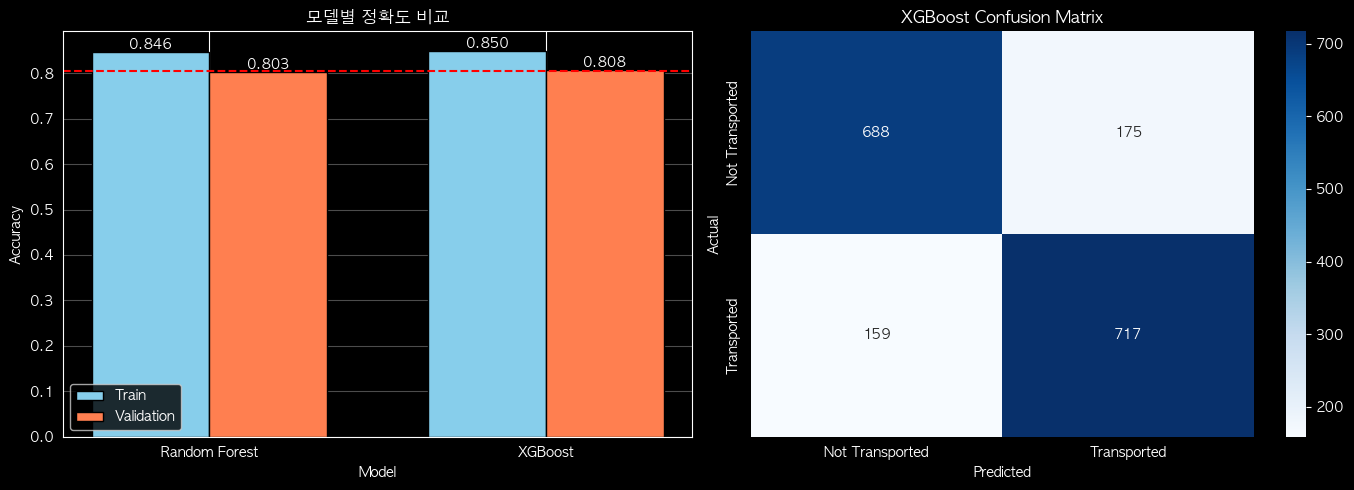


11-4. 특성 중요도 분석

[Top 15 중요 특성]
              Feature  Importance
9         HasSpending    0.690401
23             Deck_G    0.089564
21             Deck_E    0.034890
5        ShoppingMall    0.017332
4           FoodCourt    0.014945
6                 Spa    0.013142
15    HomePlanet_Mars    0.011993
22             Deck_F    0.011717
3         RoomService    0.010676
8       TotalSpending    0.010565
7              VRDeck    0.010539
14  HomePlanet_Europa    0.009380
19             Deck_C    0.008318
29      AgeGroup_Teen    0.008312
25             Side_S    0.007132


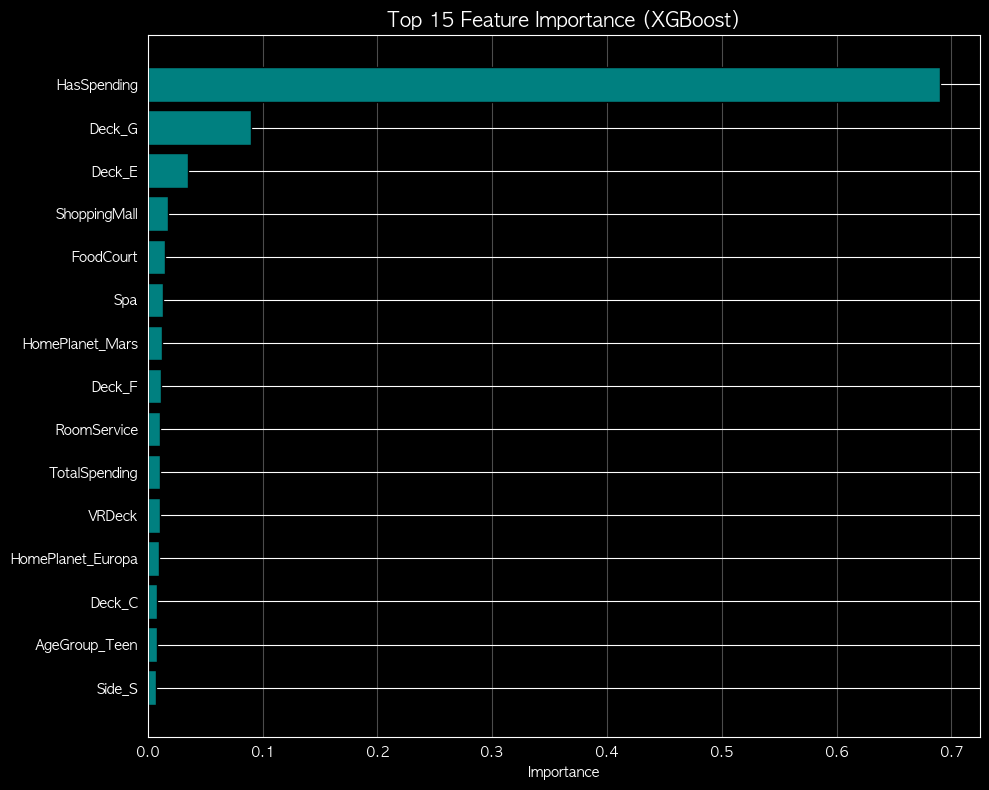


11-5. 목표 달성 확인
❌ Random Forest: 목표 미달성 (80.28% < 80.5%)
✅ XGBoost: 목표 달성! (80.79% >= 80.5%)

💡 모델링 인사이트:
- 두 모델의 성능 비교
- 과적합(Overfitting) 정도 확인
- 주요 특성 파악


In [38]:
# ============================================================
# 11. 머신러닝 모델 학습 및 평가
# ============================================================

print("=" * 60)
print("11-1. Baseline 모델 - Random Forest")
print("=" * 60)

# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1 #cpu 사용옵션  -1 병열처리( 속도빠름)
)

# 모델 학습
print("\n🔄 Random Forest 학습 중...")
rf_model.fit(X_train, y_train)

# 예측
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

# 평가
train_acc_rf = accuracy_score(y_train, y_train_pred_rf)
val_acc_rf = accuracy_score(y_val, y_val_pred_rf)

print(f"\n✅ Random Forest 결과:")
print(f"   Train 정확도: {train_acc_rf:.4f} ({train_acc_rf*100:.2f}%)")
print(f"   Validation 정확도: {val_acc_rf:.4f} ({val_acc_rf*100:.2f}%)")

# ============================================================
# 11-2. XGBoost 모델
# ============================================================

print("\n" + "=" * 60)
print("11-2. XGBoost 모델")
print("=" * 60)

# XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='logloss'
)

# 모델 학습
print("\n🔄 XGBoost 학습 중...")
xgb_model.fit(X_train, y_train)

# 예측
y_train_pred_xgb = xgb_model.predict(X_train)
y_val_pred_xgb = xgb_model.predict(X_val)

# 평가
train_acc_xgb = accuracy_score(y_train, y_train_pred_xgb)
val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)

print(f"\n✅ XGBoost 결과:")
print(f"   Train 정확도: {train_acc_xgb:.4f} ({train_acc_xgb*100:.2f}%)")
print(f"   Validation 정확도: {val_acc_xgb:.4f} ({val_acc_xgb*100:.2f}%)")

# ============================================================
# 11-3. 모델 비교
# ============================================================

print("\n" + "=" * 60)
print("11-3. 모델 성능 비교")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Train Accuracy': [train_acc_rf, train_acc_xgb],
    'Validation Accuracy': [val_acc_rf, val_acc_xgb],
    'Overfit Gap': [train_acc_rf - val_acc_rf, train_acc_xgb - val_acc_xgb]
})

display(comparison_df)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 정확도 비교
models = ['Random Forest', 'XGBoost']
train_accs = [train_acc_rf, train_acc_xgb]
val_accs = [val_acc_rf, val_acc_xgb]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, train_accs, width, label='Train', color='skyblue', edgecolor='black')
axes[0].bar(x + width/2, val_accs, width, label='Validation', color='coral', edgecolor='black')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('모델별 정확도 비교', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].axhline(y=0.805, color='red', linestyle='--', label='목표: 80.5%')
axes[0].grid(axis='y', alpha=0.3)

# 값 표시
for i, (train, val) in enumerate(zip(train_accs, val_accs)):
    axes[0].text(i - width/2, train, f'{train:.3f}', ha='center', va='bottom', fontweight='bold')
    axes[0].text(i + width/2, val, f'{val:.3f}', ha='center', va='bottom', fontweight='bold')

# Confusion Matrix (더 좋은 모델 선택)
better_model = 'XGBoost' if val_acc_xgb > val_acc_rf else 'Random Forest'
better_pred = y_val_pred_xgb if val_acc_xgb > val_acc_rf else y_val_pred_rf

cm = confusion_matrix(y_val, better_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])
axes[1].set_title(f'{better_model} Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# ============================================================
# 11-4. 특성 중요도 (Feature Importance)
# ============================================================

print("\n" + "=" * 60)
print("11-4. 특성 중요도 분석")
print("=" * 60)

# XGBoost Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n[Top 15 중요 특성]")
print(feature_importance.head(15))

# 시각화
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['Importance'], color='teal', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (XGBoost)', fontweight='bold', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 11-5. 목표 달성 확인
# ============================================================

print("\n" + "=" * 60)
print("11-5. 목표 달성 확인")
print("=" * 60)

target_accuracy = 0.805

if val_acc_rf >= target_accuracy:
    print(f"✅ Random Forest: 목표 달성! ({val_acc_rf*100:.2f}% >= 80.5%)")
else:
    print(f"❌ Random Forest: 목표 미달성 ({val_acc_rf*100:.2f}% < 80.5%)")

if val_acc_xgb >= target_accuracy:
    print(f"✅ XGBoost: 목표 달성! ({val_acc_xgb*100:.2f}% >= 80.5%)")
else:
    print(f"❌ XGBoost: 목표 미달성 ({val_acc_xgb*100:.2f}% < 80.5%)")

print("\n💡 모델링 인사이트:")
print("- 두 모델의 성능 비교")
print("- 과적합(Overfitting) 정도 확인")
print("- 주요 특성 파악")
if max(val_acc_rf, val_acc_xgb) < target_accuracy:
    print("- 다음 단계: 하이퍼파라미터 튜닝 필요")

12-1. Random Forest 하이퍼파라미터 튜닝

🔄 Random Forest GridSearchCV 시작...
탐색할 파라미터 조합 수: 108개
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Random Forest 최적 파라미터:
{'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
✅ 최고 CV 점수: 0.7994 (79.94%)
✅ Validation 정확도: 0.8068 (80.68%)

12-2. XGBoost 하이퍼파라미터 튜닝

🔄 XGBoost GridSearchCV 시작...
탐색할 파라미터 조합 수: 432개
⚠️  시간이 오래 걸릴 수 있습니다... (약 5-10분)
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

✅ XGBoost 최적 파라미터:
{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
✅ 최고 CV 점수: 0.8041 (80.41%)
✅ Validation 정확도: 0.8160 (81.60%)

12-3. 튜닝 전후 성능 비교


,Model,Validation Accuracy,Improvement
0,RF (Before),0.802760,0.000000
1,RF (After),0.806786,0.004025
2,XGB (Before),0.807936,0.000000
3,XGB (After),0.815986,0.008051


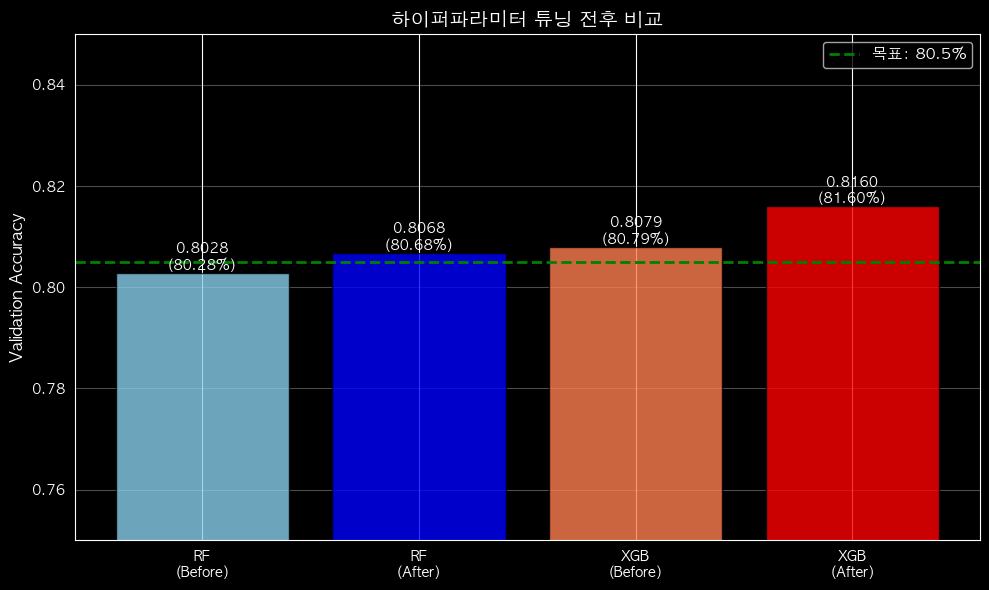


12-4. 최종 모델 선택

✅ 최종 선택 모델: XGBoost (Tuned)
✅ Validation 정확도: 0.8160 (81.60%)

🎉 목표 달성! (81.60% >= 80.5%)

12-5. 최종 모델 상세 평가

[Classification Report]
                 precision    recall  f1-score   support

Not Transported       0.82      0.81      0.81       863
    Transported       0.81      0.82      0.82       876

       accuracy                           0.82      1739
      macro avg       0.82      0.82      0.82      1739
   weighted avg       0.82      0.82      0.82      1739



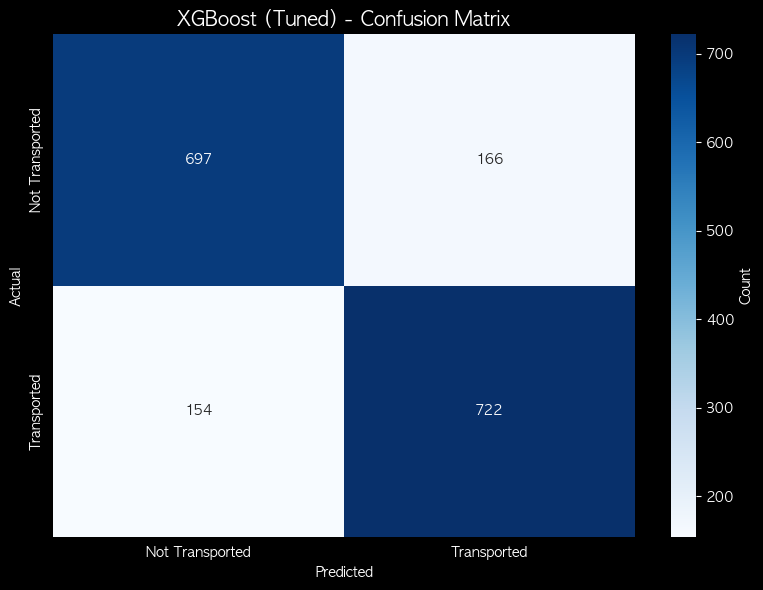


💡 튜닝 결과 인사이트:
- 최종 모델: XGBoost (Tuned)
- 검증 정확도: 81.60%
- 다음 단계: Test 데이터 예측 및 제출 파일 생성


In [39]:
# ============================================================
# 12. 하이퍼파라미터 튜닝
# ============================================================

print("=" * 60)
print("12-1. Random Forest 하이퍼파라미터 튜닝")
print("=" * 60)

# Random Forest 파라미터 그리드
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("\n🔄 Random Forest GridSearchCV 시작...")
print(f"탐색할 파라미터 조합 수: {np.prod([len(v) for v in rf_param_grid.values()])}개")

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid=rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train)

print(f"\n✅ Random Forest 최적 파라미터:")
print(rf_grid.best_params_)
print(f"✅ 최고 CV 점수: {rf_grid.best_score_:.4f} ({rf_grid.best_score_*100:.2f}%)")

# 최적 모델로 예측
rf_best = rf_grid.best_estimator_
y_val_pred_rf_best = rf_best.predict(X_val)
val_acc_rf_best = accuracy_score(y_val, y_val_pred_rf_best)

print(f"✅ Validation 정확도: {val_acc_rf_best:.4f} ({val_acc_rf_best*100:.2f}%)")

# ============================================================
# 12-2. XGBoost 하이퍼파라미터 튜닝
# ============================================================

print("\n" + "=" * 60)
print("12-2. XGBoost 하이퍼파라미터 튜닝")
print("=" * 60)

# XGBoost 파라미터 그리드
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

print("\n🔄 XGBoost GridSearchCV 시작...")
print(f"탐색할 파라미터 조합 수: {np.prod([len(v) for v in xgb_param_grid.values()])}개")
print("⚠️  시간이 오래 걸릴 수 있습니다... (약 5-10분)")

# GridSearchCV
xgb_grid = GridSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1, eval_metric='logloss'),
    param_grid=xgb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)

print(f"\n✅ XGBoost 최적 파라미터:")
print(xgb_grid.best_params_)
print(f"✅ 최고 CV 점수: {xgb_grid.best_score_:.4f} ({xgb_grid.best_score_*100:.2f}%)")

# 최적 모델로 예측
xgb_best = xgb_grid.best_estimator_
y_val_pred_xgb_best = xgb_best.predict(X_val)
val_acc_xgb_best = accuracy_score(y_val, y_val_pred_xgb_best)

print(f"✅ Validation 정확도: {val_acc_xgb_best:.4f} ({val_acc_xgb_best*100:.2f}%)")

# ============================================================
# 12-3. 튜닝 전후 비교
# ============================================================

print("\n" + "=" * 60)
print("12-3. 튜닝 전후 성능 비교")
print("=" * 60)

comparison_tuning = pd.DataFrame({
    'Model': ['RF (Before)', 'RF (After)', 'XGB (Before)', 'XGB (After)'],
    'Validation Accuracy': [val_acc_rf, val_acc_rf_best, val_acc_xgb, val_acc_xgb_best],
    'Improvement': [0, val_acc_rf_best - val_acc_rf, 0, val_acc_xgb_best - val_acc_xgb]
})

display(comparison_tuning)

# 시각화
fig, ax = plt.subplots(figsize=(10, 6))

models = ['RF\n(Before)', 'RF\n(After)', 'XGB\n(Before)', 'XGB\n(After)']
accuracies = [val_acc_rf, val_acc_rf_best, val_acc_xgb, val_acc_xgb_best]
colors = ['skyblue', 'blue', 'coral', 'red']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', alpha=0.8)

ax.axhline(y=0.805, color='green', linestyle='--', linewidth=2, label='목표: 80.5%')
ax.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_title('하이퍼파라미터 튜닝 전후 비교', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0.75, 0.85])

# 값 표시
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}\n({acc*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================
# 12-4. 최종 모델 선택
# ============================================================

print("\n" + "=" * 60)
print("12-4. 최종 모델 선택")
print("=" * 60)

# 최고 성능 모델 선택
best_val_acc = max(val_acc_rf_best, val_acc_xgb_best)

if val_acc_xgb_best >= val_acc_rf_best:
    final_model = xgb_best
    final_model_name = 'XGBoost (Tuned)'
    final_val_acc = val_acc_xgb_best
else:
    final_model = rf_best
    final_model_name = 'Random Forest (Tuned)'
    final_val_acc = val_acc_rf_best

print(f"\n✅ 최종 선택 모델: {final_model_name}")
print(f"✅ Validation 정확도: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# 목표 달성 확인
target_accuracy = 0.805

if final_val_acc >= target_accuracy:
    print(f"\n🎉 목표 달성! ({final_val_acc*100:.2f}% >= 80.5%)")
else:
    print(f"\n⚠️  목표 미달성 ({final_val_acc*100:.2f}% < 80.5%)")
    print("   추가 개선 방안:")
    print("   1. 더 많은 파생 변수 생성")
    print("   2. 앙상블 기법 (Voting, Stacking)")
    print("   3. 이상치 제거")
    print("   4. 스케일링 적용")

# ============================================================
# 12-5. 최종 모델 평가
# ============================================================

print("\n" + "=" * 60)
print("12-5. 최종 모델 상세 평가")
print("=" * 60)

# Classification Report
print("\n[Classification Report]")
print(classification_report(y_val, final_model.predict(X_val),
                          target_names=['Not Transported', 'Transported']))

# Confusion Matrix
cm_final = confusion_matrix(y_val, final_model.predict(X_val))

plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'],
            cbar_kws={'label': 'Count'})
plt.title(f'{final_model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n💡 튜닝 결과 인사이트:")
print(f"- 최종 모델: {final_model_name}")
print(f"- 검증 정확도: {final_val_acc*100:.2f}%")
print("- 다음 단계: Test 데이터 예측 및 제출 파일 생성")

In [41]:
# ============================================================
# 13. Test 데이터 예측 및 제출 파일 생성
# ============================================================

print("=" * 60)
print("13-1. 전체 Train 데이터로 최종 모델 재학습")
print("=" * 60)

# 전체 Train 데이터로 최종 모델 재학습 (성능 극대화)
print(f"\n{final_model_name} 재학습 중...")
final_model.fit(X_train_full, y_train_full)

print("전체 Train 데이터로 재학습 완료")

# ============================================================
# 13-2. Test 데이터 예측
# ============================================================

print("\n" + "=" * 60)
print("13-2. Test 데이터 예측")
print("=" * 60)

# Test 데이터 컬럼 순서 맞추기 (중요!)
X_test_aligned = X_test[X_train_full.columns]

print(f"\nTest 데이터 shape: {X_test_aligned.shape}")
print(f"Train 데이터 shape: {X_train_full.shape}")
print(f"컬럼 일치 여부: {list(X_test_aligned.columns) == list(X_train_full.columns)}")

# 예측
print("\nTest 데이터 예측 중...")
test_predictions = final_model.predict(X_test_aligned)

print(f"예측 완료!")
print(f"예측된 값 개수: {len(test_predictions)}개")
print(f"Transported=True 예측: {(test_predictions == 1).sum()}명 ({(test_predictions == 1).sum()/len(test_predictions)*100:.1f}%)")
print(f"Transported=False 예측: {(test_predictions == 0).sum()}명 ({(test_predictions == 0).sum()/len(test_predictions)*100:.1f}%)")

# ============================================================
# 13-3. 제출 파일 생성
# ============================================================

print("\n" + "=" * 60)
print("13-3. 제출 파일 생성")
print("=" * 60)

# 원본 test.csv에서 PassengerId 가져오기
original_test = pd.read_csv('/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/test.csv')
passenger_ids = original_test['PassengerId']

# Boolean 값으로 변환 (True/False)
test_predictions_bool = test_predictions.astype(bool)

# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': test_predictions_bool
})

print("\n[제출 파일 미리보기]")
display(submission.head(10))

# CSV 파일로 저장
submission_filename = '/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/spaceship_titanic_submission.csv'
submission.to_csv(submission_filename, index=False)

print(f"\n제출 파일 저장 완료: {submission_filename}")

# ============================================================
# 13-4. 제출 파일 검증
# ============================================================

print("\n" + "=" * 60)
print("13-4. 제출 파일 검증")
print("=" * 60)

# 파일 읽어서 확인
submission_check = pd.read_csv(submission_filename)

print("\n[검증 결과]")
print(f"행 개수: {len(submission_check)} (예상: {len(original_test)})")
print(f"컬럼: {list(submission_check.columns)} (예상: ['PassengerId', 'Transported'])")
print(f"결측치: {submission_check.isnull().sum().sum()}개")
print(f"PassengerId 중복: {submission_check['PassengerId'].duplicated().sum()}개")
print(f"Transported 데이터 타입: {submission_check['Transported'].dtype}")

# Transported 분포 확인
print(f"\n[예측 분포]")
print(submission_check['Transported'].value_counts())

# 샘플 제출 파일과 비교
sample_submission = pd.read_csv('/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/sample_submission.csv')
print(f"\n[샘플 제출 파일 형식 일치 여부]")
print(f"컬럼 일치: {list(submission_check.columns) == list(sample_submission.columns)}")
print(f"행 개수 일치: {len(submission_check) == len(sample_submission)}")

if len(submission_check) == len(sample_submission) and \
   list(submission_check.columns) == list(sample_submission.columns) and \
   submission_check.isnull().sum().sum() == 0:
    print("\n제출 파일이 올바르게 생성되었습니다!")
else:
    print("\n제출 파일에 문제가 있을 수 있습니다. 다시 확인해주세요.")

# ============================================================
# 13-5. 프로젝트 최종 요약
# ============================================================

print("\n" + "=" * 60)
print("13-5. 프로젝트 최종 요약")
print("=" * 60)

print("\n[데이터 정보]")
print(f"  - Train 데이터: {len(train_df)} 승객")
print(f"  - Test 데이터: {len(test_df)} 승객")
print(f"  - 생성된 파생 변수: 15개")

print("\n[전처리]")
print("  - 결측치 처리 완료")
print("  - Cabin -> Deck/Num/Side 분리")
print("  - PassengerId -> Group/GroupSize 추출")
print("  - Name -> LastName/FamilySize 추출")
print("  - 소비 변수 -> TotalSpending 생성")
print("  - One-Hot Encoding 완료")

print("\n[모델링]")
print(f"  - 최종 모델: {final_model_name}")
print(f"  - Validation 정확도: {final_val_acc*100:.2f}%")
print(f"  - 목표 달성: {'YES' if final_val_acc >= 0.805 else 'NO'}")

print("\n[산출물]")
print(f"  - 제출 파일: {submission_filename}")
print(f"  - 예측 개수: {len(submission)} 승객")

print("\n" + "=" * 60)
print("Space Titanic 프로젝트 완료!")
print("=" * 60)


13-1. 전체 Train 데이터로 최종 모델 재학습

XGBoost (Tuned) 재학습 중...
전체 Train 데이터로 재학습 완료

13-2. Test 데이터 예측

Test 데이터 shape: (4277, 35)
Train 데이터 shape: (8693, 35)
컬럼 일치 여부: True

Test 데이터 예측 중...
예측 완료!
예측된 값 개수: 4277개
Transported=True 예측: 2240명 (52.4%)
Transported=False 예측: 2037명 (47.6%)

13-3. 제출 파일 생성

[제출 파일 미리보기]


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True



제출 파일 저장 완료: /Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/spaceship_titanic_submission.csv

13-4. 제출 파일 검증

[검증 결과]
행 개수: 4277 (예상: 4277)
컬럼: ['PassengerId', 'Transported'] (예상: ['PassengerId', 'Transported'])
결측치: 0개
PassengerId 중복: 0개
Transported 데이터 타입: bool

[예측 분포]
Transported
True     2240
False    2037
Name: count, dtype: int64

[샘플 제출 파일 형식 일치 여부]
컬럼 일치: True
행 개수 일치: True

제출 파일이 올바르게 생성되었습니다!

13-5. 프로젝트 최종 요약

[데이터 정보]
  - Train 데이터: 8693 승객
  - Test 데이터: 4277 승객
  - 생성된 파생 변수: 15개

[전처리]
  - 결측치 처리 완료
  - Cabin -> Deck/Num/Side 분리
  - PassengerId -> Group/GroupSize 추출
  - Name -> LastName/FamilySize 추출
  - 소비 변수 -> TotalSpending 생성
  - One-Hot Encoding 완료

[모델링]
  - 최종 모델: XGBoost (Tuned)
  - Validation 정확도: 81.60%
  - 목표 달성: YES

[산출물]
  - 제출 파일: /Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/spaceship_titanic_submission.csv
  - 예측 개수: 4277 승객

Space Titanic 프로젝트 완료!


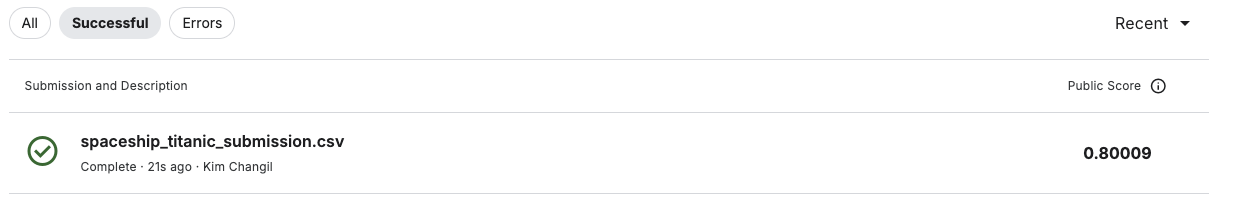

In [2]:
# 코드 셀에 추가
from IPython.display import Image
Image('/Users/macminim4/PyCharmMiscProject/Aiffel/jan/data/spaceship-titanic/image_kaggle.png')
